# Information
Final project in 02805 Social graphs and interactions at DTU, Fall 2020.

Website: https://network-of-actors.github.io/

Github: https://github.com/network-of-actors/network-of-actors.github.io

Note: This notebook should be openend in Google Colab, otherwise the plotly plots might not be visible. Alternatively, we refer to the website for the plots. 

In [1]:
from IPython.display import HTML

# Imports and preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.graph_objects as go

import plotly.express as px
import plotly.tools as tls
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import re

from bs4 import BeautifulSoup
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pickle
import networkx as nx
import community
from fa2 import ForceAtlas2
from PIL import Image
from datetime import datetime

! pip install pycountry
import pycountry

import json
import itertools

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings('ignore')

import requests
import itertools

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 10.1MB 4.6MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=624916f9dec1bf59ec00735189ce8ddb10aff3c4cebc76d264565ae9b56843fb
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  lib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#mount_path = '/content/drive/MyDrive/02805 Social Graphs Assignments/Project Assignment/Data/'
mount_path = '/content/drive/MyDrive/DTU/02805 Social Graphs Assignments/Project Assignment/Data/'

# 1. Motivation

## Introduction

### Topic and general idea of the network
In this project we have decided to look into the network of actors. The topic has been selected based on the idea that this is something that both we and most of our peers can relate to. We expect that our general knowledge about the topic will provide a good basis for a thorough analysis of the network. 

The data set is created with basis in a list of movies. For each movie the actors featured in the main cast are extracted. From this data set a bipartite graph can be created, with one set of nodes representing the movies and one set of nodes representing the actors. A movie-node and an actor-node are connected if and only if the actor was part of the main cast of the movie. In this project, we have chosen to work with the projection of the bipartite graph with respect to the actor nodes. In the projected graph only the actors are featured as nodes; two nodes are then connected if they have been part of the main cast of the same movie. If two actors are featured in several of the same movies, they will technically be connected by a corresponding number of edges. However, instead of having multiple edges between the same pair of nodes, we have chosen to only have one edge between them, and then give the edge a weight corresponding to the number of common movies between the two actors. 

### Plan for analysis

Several analyses will be performed on the network. First, of all a temporal analysis will be performed, in order to get an impression of how the network of actors has developed over time. Furthermore, we will look further into the different genres of the movies represented in the data set, to see whether we can see some patterns among the movies of the different genres and among the actors typically starring in movies of the different genres. Part of this analysis will be a text analysis, where the descriptions of plots of the movies will be analyzed in order to get an impression of the typical topics within each genre. Finally, we will perform a community partition of the network, and based on this, we will try to detect some of the natural communities among actors in the real world. 

### User experience
Since we have chosen a data set which most people can relate to without any technical knowledge, the user experience has been a big part of the considerations during this project. We aim to give the user some interesting insights into the network of actors, and to present the results in a way which is easily understood. For example, we will aim to display pictures of important actors rather than just names, since many people are better at remembering faces than names.

## Creating the data set

We have chosen to use IMDB as the source of the data extraction, since IMDB contains a lot of useful information about both the movies and the actors listed in the database. Furthermore, a thorough plot synopsis and a long list of plot key words are provided for most of the movies on IMDB, which will be a very good basis for the text analysis.

The data set is based on the list of the 1000 highest user rated movies on IMDB (https://www.imdb.com/search/title/?count=100&groups=top_1000&sort=user_rating). 

### Movie `DataFrame`

First, the list was scraped to get the titles and the IMDB movie IDs for all the movies on the list. Since the list only shows 50 movies per page, the sub-parts of the list are scraped one at a time.

In [ ]:
def get_movie_ids(num):
  url = f"https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&start={num}&ref_=adv_nxt"
  r = requests.get(url=url)
  info = str(BeautifulSoup(r.text, 'html.parser')) 

  reg = '\/title\/(tt[0-9]+)\/">(\w[\w\s\:\-\,\'\.]+)'
  movie_ids = re.findall(reg, info)
  if len(movie_ids) != 50:
    print(num)
  return movie_ids

In [ ]:
numbers = np.arange(1,1000,50)
movie_ids = []
for num in numbers:
  movie_ids += get_movie_ids(str(num))

The results are collected in a `DataFrame`, which naturally contains 1000 rows.

In [ ]:
df_movies = pd.DataFrame(movie_ids, columns =['MovieID', 'Title']) 
print(f"Number of rows: {len(df_movies)}")
df_movies.head()

Number of rows: 1000


MovieID                     Title
0  tt0111161  The Shawshank Redemption
1  tt0068646             The Godfather
2  tt0468569           The Dark Knight
3  tt0071562    The Godfather: Part II
4  tt0050083              12 Angry Men

For each movie, the HTML code of four IMDB pages is extracted. The four pages are: 

*   The actual IMDB page of the movie (example: https://www.imdb.com/title/tt0111161/)
*   The IMDB page containing the plot synopsis of the movie (example: https://www.imdb.com/title/tt0111161/plotsummary)
*   The IMDB page containing the plot key words of the movie (example: https://www.imdb.com/title/tt0111161/keywords)
*   The IMDB page containing the full credits (cast) of the movie (example: https://www.imdb.com/title/tt0111161/fullcredits)



In [ ]:
def find_movie_imdb_info(movie_id):
    info_url = f"https://www.imdb.com/title/{movie_id}/"
    summary_url = f"https://www.imdb.com/title/{movie_id}/plotsummary"
    keyword_url = f"https://www.imdb.com/title/{movie_id}/keywords"
    actor_url = f"https://www.imdb.com/title/{movie_id}/fullcredits"

    r = requests.get(url=info_url)
    info = str(BeautifulSoup(r.text, 'html.parser'))
    
    r = requests.get(url=summary_url)
    summary_info = str(BeautifulSoup(r.text, 'html.parser'))

    r = requests.get(url=keyword_url)
    keyword_info = str(BeautifulSoup(r.text, 'html.parser'))

    r = requests.get(url=actor_url)
    credits = str(BeautifulSoup(r.text, 'html.parser'))

    return info, summary_info, keyword_info, credits

In [ ]:
df_movies["HTML"], df_movies["SummaryHTML"], df_movies['KeywordHTML'], df_movies["ActorHTML"] = zip(*df_movies["MovieID"].apply(lambda x : find_movie_imdb_info(x)))
df_movies.head()

MovieID  ...                                          ActorHTML
0  tt0111161  ...  \n<!DOCTYPE html>\n\n<html xmlns:fb="http://ww...
1  tt0068646  ...  \n<!DOCTYPE html>\n\n<html xmlns:fb="http://ww...
2  tt0468569  ...  \n<!DOCTYPE html>\n\n<html xmlns:fb="http://ww...
3  tt0071562  ...  \n<!DOCTYPE html>\n\n<html xmlns:fb="http://ww...
4  tt0050083  ...  \n<!DOCTYPE html>\n\n<html xmlns:fb="http://ww...

[5 rows x 6 columns]

From the HTML code, a number of attributes are then extracted using regular expressions. 

First the **plot synopsis** is extracted for each movie:

In [ ]:
def find_plot_synopsis(summary_info):
    synopsis = re.findall("(?s)id=\"synopsis-py[0-9]+\"\>(.*)(?=[\".!?\])a-zA-Z]\<\/li\>)", summary_info)
    if len(synopsis) > 0: 
        synopsis = synopsis[0]
    else: 
        synopsis = None

    return synopsis

In [ ]:
df_movies["PlotSynopsis"] = df_movies["SummaryHTML"].apply(lambda x : find_plot_synopsis(x))

The plot synopsis is a very important attribute, since this is the main basis for the upcoming text analysis. However, some movies do not have a plot synopsis on IMDB. These movies are removed from the data set. 

In [ ]:
num_without = len(df_movies[df_movies["PlotSynopsis"].isna()])
print(f"{num_without} movies are removed due to missing plot synopsis.")
df_movies = df_movies[~df_movies["PlotSynopsis"].isna()]
df_movies.reset_index(drop = True, inplace = True)
print(f"The DataFrame now contains {len(df_movies)} rows.")

138 movies are removed due to missing plot synopsis.
The DataFrame now contains 862 rows.


Now the following attributes are extracted from the HTML code of the remaning movies: 

*   Release year
*   Actors in main cast
*   Directors
*   Creators
*   Genres
*   Key words
*   Release country
*   Budget
*   Income

In [ ]:
# Release year
def release_year(IMDB_info):
    reg = "Release Date:<\/h4>.*?(?=[0-9]{4})([0-9]{4})"
    date = re.findall(reg, IMDB_info)
    return date[0]

# Actors in main cast
def find_actors(actor_html):
  reg_cast = '(?s)class="dataHeaderWithBorder" id="cast" name="cast">(.*?)(?=Rest of cast)'
  cast = re.findall(reg_cast, actor_html)
  if len(cast)<1:
    reg_cast = '(?s)class="dataHeaderWithBorder" id="cast" name="cast">(.*?)(?=dataHeaderWithBorder)'
    cast = re.findall(reg_cast, actor_html)

  reg_actor = '(nm[0-9]+)\/">([\w\s\.]+)'
  actors = re.findall(reg_actor, cast[0])
  num_actor = [(ele[0], ele[1].strip()) for ele in actors]
  return list(list(zip(*num_actor))[0]), list(list(zip(*num_actor))[1])

# Directors
def find_directors(html):
  reg_director = "(?s)director\": (.*)(?=\"creator\")"
  director_text = re.findall(reg_director, html)
  if len(director_text) > 0:
    return re.findall("\"name\": \"([\w\s]+)\"", director_text[0])
  else:
    return None

# Creators
def find_creators(html):
  reg_creator = "(?s)creator\": (.*)(?=\"description\")"
  creator_text = re.findall(reg_creator, html)
  if len(creator_text) > 0:
    return re.findall("\"name\": \"([\w\s]+)\"", creator_text[0])
  else:
    return None

# Genres
def find_genres(IMDB_info):
    genres = re.findall("title\?genres\=([\w\s\-]+)", IMDB_info)
    genres = list(np.unique(genres))
    if len(genres) < 1: 
      genres = None
    return genres

# Key words
def get_keywords(keyword_html):
  keywords = re.findall('data-item-keyword="(.*?)(?=")', keyword_html)
  return keywords

# Release country
def get_release_country(html):
  country = re.findall("country_of_origin=.*?(?=>)>(.*?)(?=<)", html)
  if len(country)<1:
    country = [None]
  return country[0]

# Budget and income
def get_budget_income(html):
  budget = re.findall("Budget:<\/h4>\$(.*?)(?=\\n)", html)
  income = re.findall("Cumulative Worldwide Gross:<\/h4> \$(.*?)(?=<)", html)
  if len(budget)<1:
    budget = None
  else: 
    budget = int(budget[0].replace(',','').strip())
  if len(income)<1:
    income = None
  else: 
    income = int(income[0].replace(',','').strip())
  return budget, income

In [ ]:
df_movies["ReleaseYear"] = df_movies["HTML"].apply(lambda x : release_date(x))
df_movies["ActorIDs"],df_movies["ActorNames"]= zip(*df_movies["ActorHTML"].apply(lambda x : find_actors(x)))
df_movies["Directors"] = df_movies["HTML"].apply(lambda x : find_directors(x))
df_movies["Creators"] = df_movies["HTML"].apply(lambda x : find_creators(x))
df_movies["Genres"] = df_movies["HTML"].apply(lambda x : find_genres(x))
df_movies["Keywords"] = df_movies["KeywordHTML"].apply(lambda x : get_keywords(x))
df_movies["Country"] = df_movies["HTML"].apply(lambda x : get_release_country(x))
df_movies["Budget"],df_movies["Income"]= zip(*df_movies["HTML"].apply(lambda x : get_budget_income(x)))

df_movies[['MovieID', 'Title', 'PlotSynopsis', 'ReleaseYear', 'ActorIDs', 'ActorNames', 'Directors', 'Creators', 'Genres', 'Keywords', 'Country', 'Budget']].head()

MovieID                     Title  ... Country       Budget
0  tt0111161  The Shawshank Redemption  ...     USA   25000000.0
1  tt0068646             The Godfather  ...     USA    6000000.0
2  tt0468569           The Dark Knight  ...     USA  185000000.0
3  tt0071562    The Godfather: Part II  ...     USA   13000000.0
4  tt0050083              12 Angry Men  ...     USA     350000.0

[5 rows x 12 columns]

Based on the extracted attributes, the following two additional attributes are created: 

* **Decade**

  The decade in which the movie was released. If the movie was released in 2020 the decade is noted as the 2010s, since the 2020s have lasted for too short a time to be an appropriate basis for analysis. 

* **Document**

  The document is a tokenized version of text from the plot synopsis and the list of key words. When the document is created, the text is cleaned by: 
    * Removing all HTML code (e.g. links to actors)
    * Removing all punctuation
    * Converting all text to lower case
    * Lemmatizing all words
    * Removing stop words (using the NLTK list of english stop words)




In [ ]:
def find_decade(release_year):
  if release_year == 2020:
    decade = '2010s'
  else: 
    decade = str(int(np.floor(release_year/10)*10))+'s'
  
  return decade

df_movies["Decade"] = df_movies["ReleaseYear"].apply(lambda x : find_decade(x))

In [ ]:
df_movies["Document"] = None
wnl = nltk.WordNetLemmatizer()
stopwords_ = stopwords.words('english')

for idx, row in df_movies.iterrows():
  syn = BeautifulSoup(row["PlotSynopsis"]).get_text()
  full_text = syn + " " + " ".join([kw for kw in row["Keywords"]])
  words = re.sub("[^a-zA-Z\s]", " ", full_text).lower().split()
  df_movies["Document"][idx] = [wnl.lemmatize(w) for w in words if w not in stopwords_]

In [ ]:
df_movies[['MovieID', 'Title', 'Decade', 'Document']].head()

MovieID  ...                                           Document
0  tt0111161  ...  [andy, dufresne, tim, robbins, banker, maine, ...
1  tt0068646  ...  [late, summer, guest, gathered, wedding, recep...
2  tt0468569  ...  [movie, begin, gang, men, clown, mask, breakin...
3  tt0071562  ...  [godfather, part, ii, present, two, parallel, ...
4  tt0050083  ...  [new, york, city, courthouse, eighteen, year, ...

[5 rows x 4 columns]

Finally, we take a look at the number of missing values for each of the attributes: 

In [ ]:
df_movies.isna().sum()

MovieID           0
Title             0
HTML              0
SummaryHTML       0
KeywordHTML       0
ActorHTML         0
PlotSynopsis      0
ReleaseYear       0
Genres            0
ActorIDs          0
ActorNames        0
Directors         0
Creators          0
Keywords          0
Country           0
Budget          201
Income           57
Decade            0
Document          0
dtype: int64

We see that only the attributes `Budget` and `Income` contains missing values. About 23% of the movies do not have a budget registered, while about 6% of the movies do not have an income registered. It has been decided to keep the rows with the missing values, and just base upcoming analyses of budget and income on the rows which do have these attributes registered. 

The final movie `DataFrame` thus consist of: 

In [ ]:
print(f"{len(df_movies)} rows and {len(df_movies.columns)} columns.")

862 rows and 19 columns.


The movie `DataFrame` is saved as a json file. 

In [ ]:
df_movies.to_json(mount_path+'movies_dataframe_FINAL.json')

### Actors `DataFrame`

We now extract a unique list of the actors appearing in the `ActorIDs` of the movies `DataFrame`. I.e. a list of all the actors which is part of the main cast in any of the movies in the data set. 

In [ ]:
unique_actor_ids, counts = np.unique(np.concatenate(df_movies['ActorIDs']), return_counts=True)
print(f"{len(unique_actor_ids)} unique actors appear in the data set.")


28862 unique actors appear in the data set.


An actors `DataFrame` is now created with the IMDB IDs of these actors. 

In [ ]:
df_actors = pd.DataFrame(columns = ["ActorID"], data = unique_actor_ids)
df_actors.head()

ActorID
0  nm0000002
1  nm0000004
2  nm0000006
3  nm0000007
4  nm0000008

For each actor the HTML code of the corresponding IMDB page is extraxted (example: https://www.imdb.com/name/nm0000210/)

In [ ]:
def get_actor_html(actor_id): 
  actor_url = f"https://www.imdb.com/name/{actor_id}/"
  r = requests.get(url=actor_url)
  info = str(BeautifulSoup(r.text, 'html.parser'))
  return info

In [ ]:
df_actors['ActorHTML'] = df_actors["ActorID"].apply(lambda x : get_actor_html(x))

From the HTML code, the following attributes are then extracted using regular expressions: 

*   Name
*   Birthday 
*   Birth place

After the extraction of the attributes, the HTML code is removed from the dataframe for efficiency. 

In [ ]:
# Name
def get_name(actor_html):
  name = re.findall('"name": "(.*?)(?=")', actor_html)
  if len(name)<1:
    name = [None]
  return name[0]

# Birth date and birth place
def get_birthdate_and_place(actor_html):
  birth = re.findall('"birthDate": "(.*?)(?=")', actor_html)
  place = re.findall('birth_place=.*?(?=>)>(.*?)(?=<)', actor_html)
  if len(birth)<1:
    birth = [None]

  if len(place)<1:
    place = [None]

  return birth[0], place[0]

In [ ]:
df_actors['ActorName'] = df_actors["ActorHTML"].apply(lambda x : get_actor_html(x))
df_actors["Birthday"], df_actors["BirthPlace"]= zip(*df_actors["ActorHTML"].apply(lambda x : get_birthdate_and_place(x)))

In [ ]:
df_actors = df_actors[['ActorID', 'ActorName', 'Birthday', 'BirthPlace']]
df_actors.head()

ActorID  ...                               BirthPlace
0  nm0000002  ...  The Bronx, New York City, New York, USA
1  nm0000004  ...                   Chicago, Illinois, USA
2  nm0000006  ...                        Stockholm, Sweden
3  nm0000007  ...             New York City, New York, USA
4  nm0000008  ...                     Omaha, Nebraska, USA

[5 rows x 4 columns]

From the extracted attribute `BirthPlace` the birth country of the actor is then estimated using the package `pycountry`.


In [ ]:
def find_birth_country(birthplace):
  if birthplace is not None:
    country_dict = {"USA" : "United States", 
                    "Nebraska" : "United States", 
                    "New Jersey" : "United States", 
                    "UK" : "United Kingdom", 
                    "London" : "United Kingdom", 
                    "USSR" : "Russian Federation",
                    "Soviet Union" : "Russian Federation",
                    "Russia" : "Russian Federation"}
                  
    for key, value in country_dict.items(): 
      birthplace = birthplace.replace(key, value)

    for country in pycountry.countries:
        if country.name in birthplace:
            return country.name
    
    return None

In [ ]:
df_actors["BirthCountry"] = df_actors["BirthPlace"].apply(lambda x : find_birth_country(x))
df_actors.head()

ActorID  ...   BirthCountry
0  nm0000002  ...  United States
1  nm0000004  ...  United States
2  nm0000006  ...         Sweden
3  nm0000007  ...  United States
4  nm0000008  ...  United States

[5 rows x 5 columns]

Finally, a number of attributes are created connecting the actors to the movies of the movie `DataFrame`. First of all an attribute `MovieIDs` is created consising of the movie IDs for all the movies in which the actor was featured as part of the main cast. Furthermore we create an attribute for each decade and genre represented in the movie data set. Each attribute contains a list of the movie IDs for the movies within the specific genre or decade, in which the actor was part of the main cast. 

In [ ]:
genres = list(np.unique(np.concatenate(df_movies['Genres'])))
decades = list(sorted(df_movies["Decade"].unique()))

decade_dfs = {}
for decade in decades: 
  decade_dfs[decade] = df_movies[df_movies["Decade"] == decade].reset_index(drop = True)

genre_dfs = {}
for genre in genres: 
  genre_dfs[genre] = df_movies[df_movies["Genres"].apply(lambda x : genre in x)].reset_index(drop = True)

df_actors["MovieIDs"] = None
for decade in decades: 
  df_actors["MovieIDs_"+decade] = None
for genre in genres: 
  df_actors["MovieIDs_"+genre] = None

total = len(df_actors)

for idx, row in df_actors.iterrows():

  actor_id = row["ActorID"]
  
  # Find movie for each decade 
  results = []
  for decade in decades:
    df_temp = decade_dfs[decade][decade_dfs[decade]["ActorIDs"].apply(lambda x : actor_id in x)]
    ids = list(df_temp["MovieID"].values)
    df_actors.loc[idx]["MovieIDs_"+decade] = ids
    results.append(ids)

  # Find movies for each genre
  for genre in genres:
    df_temp = genre_dfs[genre][genre_dfs[genre]["ActorIDs"].apply(lambda x : actor_id in x)]
    ids = list(df_temp["MovieID"].values)
    df_actors.loc[idx]["MovieIDs_"+genre] = ids
    results.append(ids)

  # Find all movies 
  df_actors.loc[idx]["MovieIDs"] = list(np.unique(np.concatenate(results)))

In [ ]:
df_actors[['ActorID', 'ActorName'] + [column for column in df_actors.columns if 'MovieIDs' in column]].head()

ActorID  ... MovieIDs_western
0  nm0000002  ...               []
1  nm0000004  ...               []
2  nm0000006  ...               []
3  nm0000007  ...      [tt0040897]
4  nm0000008  ...               []

[5 rows x 34 columns]

Finally we take a look at the number of missing values for each attribute. Naturally it is only relevant to look at the attributes extracted from the HTML code and not the attributes related to the lists of movie IDs, since these attributes were created without the possibility of missing values.

In [ ]:
df_actors[["ActorID", "ActorName", "Birthday", "BirthPlace", "BirthCountry"]].isna().sum()

ActorID             0
ActorName           1
Birthday        15914
BirthPlace      15278
BirthCountry    15547
dtype: int64

First of all we see that one actor does not have his/her name registered. This is quickly fixed by finding the ID of the actor.

In [ ]:
df_actors[df_actors["ActorName"].isna()]["ActorID"]

23784    nm2655834
Name: ActorID, dtype: object

We visit the corresponding IMDB page (https://www.imdb.com/name/nm2655834/) and see that the actors name is Deema Aitken. The name can then be registered manually. 

In [ ]:
df_actors.loc[23784, "ActorName"] = "Deema Aitken"

In [ ]:
df_actors[["ActorID", "ActorName", "Birthday", "BirthPlace", "BirthCountry"]].isna().sum()

ActorID             0
ActorName           0
Birthday        15914
BirthPlace      15278
BirthCountry    15547
dtype: int64

We furthermore see that the attributes `Birthday`, `BirthPlace` and `BirthCountry` are missing for about half of the actors. The rows will be kept, but the missing values will be remembered and taken into account when the attributes are used for analysis later on.

The final actors data set thus consist of: 

In [ ]:
print(f"{len(df_actors)} rows and {len(df_actors.columns)} columns.")

28862 rows and 37 columns.


The dataframe is saved to a json file.

In [ ]:
df_actors.to_json(mount_path+'actors_dataframe_FINAL.json')

## Creating the graphs

The graph representing the network of actors is now created. As previously explaned the nodes of the graph are the actors. Two actors are connected by an edge if they has been featured in the same movie, and the edge is given a weight corresponding to the number of movies which the two actors both starred in. 

In [ ]:
G_actors = nx.Graph()
G_actors.add_nodes_from(list(zip(df_actors['ActorID'], [{"ActorName": name} for name in df_actors['ActorName']])))
for idx1, row1 in df_actors.iterrows():
    name = row1["ActorID"]
    edges = []
    for idx2 in range(idx1+1,len(df_actors)):
        row2 = df_actors.loc[idx2]
        common_movies = len(list(set(row1["MovieIDs"]) & set(row2["MovieIDs"])))
        if common_movies > 0:
            edges.append((name, row2["ActorID"], common_movies))
            
    G_actors.add_weighted_edges_from(edges)

pickle.dump(G_actors, open(mount_path+'../Graphs/large_graph.txt', 'wb'))

Furthermore, a graph is created for each of the decades represented in the data set. The nodes in the graph for a decade are the actors who were active in that decade (i.e. who were in a movie which was released and the decade and which is on the top 1000 IMDB list). Two actors are connected only if they were both featured in a movie which was released the decade. If two actors were both active in e.g. the 1990s but starred together for the first time in the 2000s they will not be connected in the graph representing the 1990s. 

In [ ]:
for decade in decades: 
  df_actors_decade = df_actors[df_actors["MovieIDs_"+decade].str.len() > 0].reset_index(drop = True)
  G_actors = nx.Graph()
  G_actors.add_nodes_from(list(zip(df_actors_decade['ActorID'], [{"ActorName": id} for id in df_actors_decade['ActorName']])))
  for idx1, row1 in df_actors_decade.iterrows():
      name = row1["ActorID"]
      edges = []
      for idx2 in range(idx1+1,len(df_actors_decade)):
          row2 = df_actors_decade.loc[idx2]
          common_movies = len(list(set(row1["MovieIDs_"+decade]) & set(row2["MovieIDs_"+decade])))
          if common_movies > 0:
              edges.append((name, row2["ActorID"], common_movies))
              
      G_actors.add_weighted_edges_from(edges)

  pickle.dump(G_actors, open(mount_path+'../Graphs/graph_'+decade+'.txt', 'wb'))
  print(decade+" saved")

The specifics of the graphs will be reviewed in section 2.

# 2. Basic Statistics

## Data

First, the dataframes of the movies and actors are loaded.

In [ ]:
df_actors = pd.read_json(mount_path+'actors_dataframe_FINAL.json')
df_movies = pd.read_json(mount_path+'movies_dataframe_FINAL.json')

### Countries

First, we want to found out in which countries the 1000 movies have been produced in. To do so we find the unique list of countries and count how many movies have been produced in each country. Note, that if more than one country was listed for a movie on IMDB, the first one is considered the main country and is the only one included in this. 

In [ ]:
countries, counts = np.unique(df_movies['Country'], return_counts=True)
df_con = pd.DataFrame(columns = ["Country", "Counts"])
df_con["Country"] = countries
df_con["Counts"] = counts
print(f'Number of countries: {len(countries)}')

Number of countries: 33


We find that some of these countries do not exist anymore, so we map these to the countries they would fall under today. Since we are interested in plotting the countries on a map, we find it acceptable to do so, since the location of these 'old' countries would be the same as the ones they are mapped to. 

In [ ]:
# Combine West Germany and Germany
df_con['Counts'][df_con['Country']=='Germany'] += df_con.loc[df_con['Country'] == 'West Germany'].values[0][1]
df_con = df_con[df_con['Country'] != 'West Germany']

# Change name of Yugoslavia to Serbia
df_con['Country'][df_con['Country']=='Federal Republic of Yugoslavia'] = 'Serbia'

# Combine Russia and Soviet Union (under Russia)
df_con['Counts'][df_con['Country']=='Russia'] += df_con.loc[df_con['Country'] == 'Soviet Union'].values[0][1]
df_con = df_con[df_con['Country'] != 'Soviet Union']


Now, we want to plot these countries on a map. To do so, we read in a list of the longitude and latitude of countries. Some are named differently in our dataframe, so these are renamed.  

In [ ]:
long_lat= pd.read_csv(mount_path+'country_centroids_az8.csv')
long_lat = long_lat[["name", "Longitude", "Latitude"]]

#Rename United States to USA
long_lat['name'][long_lat['name'] == 'United States'] = 'USA'

#Rename United Kingdom to UK
long_lat['name'][long_lat['name'] == 'United Kingdom'] = 'UK'

#Rename Korea to South Korea
long_lat['name'][long_lat['name'] == 'Korea'] = 'South Korea'

We now combine the information needed and plot the countries on a map. The nodes on the graph will indicate the countries where movies are produced and the size of the nodes are adjusted according to how many movies have been produced in the respective country.

In [ ]:
coun_plot = pd.concat([df_con.set_index('Country'),long_lat.set_index('name')], axis=1, join='inner').reset_index()
coun_plot["Latitude"] = coun_plot["Latitude"].astype(float)
coun_plot["Longitude"] = coun_plot["Longitude"].astype(float)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


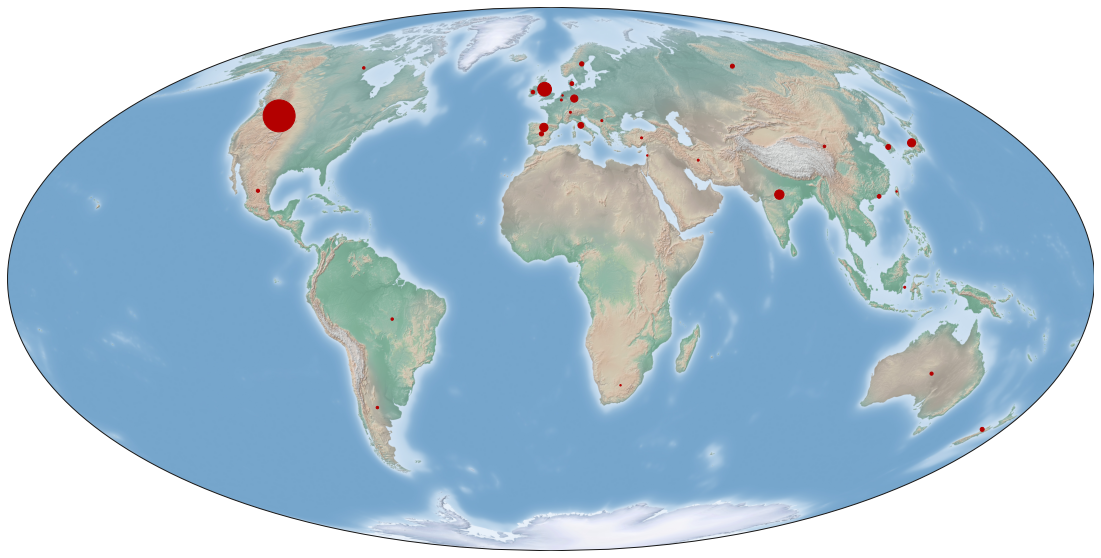

In [ ]:
fig = plt.figure(figsize=(20, 10), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
# Get positions for the countries
lats=coun_plot['Latitude']
lons=coun_plot['Longitude']
# Convert lat and lon to map projection
mx,my=m(lons,lats)

# Create network and adjust node sizes
G=nx.Graph()
G.add_nodes_from(coun_plot['index'])
node_sizes = coun_plot['Counts']*2
# Put map projection coordinates in dictionary
pos={}
for (idx, country) in enumerate(coun_plot['index']):
  pos[country]=(mx[idx], my[idx])

# Draw network
#nx.draw_networkx(G,pos,node_size=node_sizes,node_color='#b30000') #with labels
nx.draw_networkx_nodes(G,pos,node_size=node_sizes,node_color='#b30000') #without labels

# Draw the map
m.shadedrelief()
#plt.title('Movies per country')
plt.show()
fig.savefig(mount_path+"../Plots/network_world.png", format='png', dpi=600, transparent=True, bbox_inches = 'tight')

As mentioned, the red dots on the map indicate, that at least one of the movies was made in that country, and the bigger the dot, the more movies have been produced in the respective country. The plot shows that the majority of the top rated movies on the IMDB list is produced in USA. This must be expected, since the movie industry in Hollywood is very big and thus, it is natural that many of the top rated movies are produced here. However, the plot also shows that severa movies on the list have been producd in the United Kingdom, India and Japan.

### Statistics

We wish to estimate the average sentiment of each movie based on the attribute *Document*, which includes the cleanned plot synopsis and cleanned list of keywords. The sentiment of each word is based on the list found here: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752. 

In [ ]:
sentiments = pd.read_csv(mount_path+'dataset_s1.txt', sep ='\t')
sent_dict = dict(zip(sentiments['word'], sentiments['happiness_average']))

With this dict of words and their corresponding sentiments and average sentiment for each movie is found and saved as the attribute *AverageSentiment*.

In [ ]:
def compute_average_sentiment(document):
  sentiments = [sent_dict[word] for word in document if word in sent_dict.keys()]

  return np.mean(sentiments)

In [ ]:
df_movies["AverageSentiment"] = df_movies["Document"].apply(lambda x : compute_average_sentiment(x))

Now, some basic statistics of the movies are found. This includes the minimum, maximum and average budgets of the movies, the minimum, maximum and average incomes of the movies as well as the minimum, maximum and mean of average sentiment of each movie. 

In [ ]:
print('Budget')
print(f"Minimum budget for a movie: ${min(df_movies['Budget'])}")
print(f"Average budget for a movie: ${round(np.mean(df_movies['Budget']),1)}")
print(f"Maximum budget for a movie: ${max(df_movies['Budget'])}")

print()
print('Income')
print(f"Minimum income for a movie: ${min(df_movies['Income'])}")
print(f"Average income for a movie: ${round(np.mean(df_movies['Income']),1)}")
print(f"Maximum income for a movie: ${max(df_movies['Income'])}")

print()
print('Sentiment')
print(f"Minimum average sentiment score for a movie: {round(min(df_movies['AverageSentiment']),2)}")
print(f"Mean of average sentiment score for a movie: {round(np.mean(df_movies['AverageSentiment']),2)}")
print(f"Maximum average sentiment score for a movie: {round(max(df_movies['AverageSentiment']),2)}")


Budget
Minimum budget for a movie: $18000.0
Average budget for a movie: $36273423.6
Maximum budget for a movie: $356000000.0

Income
Minimum income for a movie: $108.0
Average income for a movie: $161901430.2
Maximum income for a movie: $2797800564.0

Sentiment
Minimum average sentiment score for a movie: 4.88
Mean of average sentiment score for a movie: 5.49
Maximum average sentiment score for a movie: 6.2


We find the movies with the highest and lowest sentiment scores, which will be considered the happiest, respectively, saddest movies: 

In [ ]:
print('Three happiest movies')
df_movies[['Title', 'AverageSentiment']].sort_values(by='AverageSentiment', ascending= False)[:3]

Three happiest movies


Title  AverageSentiment
600  Mary Poppins          6.201286
124         Queen          6.105044
522          Once          6.051379

In [ ]:
print('Three saddest movies')
df_movies[['Title', 'AverageSentiment']].sort_values(by='AverageSentiment', ascending= True)[:3]

Three saddest movies


Title  AverageSentiment
762  The Raid: Redemption          4.877055
510       I Saw the Devil          4.899272
771             Celda 211          4.944903

Now the happiest and saddest actors are found. This is done by finding the mean of all the average sentiment scores for the movies each actor has starred in. Here, all sentiment scores are weighted equally, but another possibility would be to weight the sentiment scores of movies relative to the length of the plot synopsis and the number of keywords, since the longer a text, the more valid is the sentiment score. However, as mentioned in the following we weight all sentiment scores equally. 

In [ ]:
def actor_sentiment(movieids):
  avg_sent = 0
  for movieid in movieids: 
    avg_sent += df_movies[df_movies['MovieID'] == movieid]['AverageSentiment'].values[0]
  return round(avg_sent/len(movieids),4) 

In [ ]:
df_actors['MeanAverageSentiment'] = df_actors['MovieIDs'].apply(lambda x: actor_sentiment(x))

Now the three happiest and three saddest actors can be found based on the sentiment scores of the movies on the IMDB list they have starred in. 

In [ ]:
print('Three happiest actors')
df_actors[['ActorName', 'MeanAverageSentiment']].sort_values(by='MeanAverageSentiment', ascending= False)[:3]

Three happiest actors


ActorName  MeanAverageSentiment
10056     Alma Lawton                6.2013
5733   Marjorie Eaton                6.2013
27326     James Logan                6.2013

In [ ]:
print('Three saddest actors')
df_actors[['ActorName', 'MeanAverageSentiment']].sort_values(by='MeanAverageSentiment', ascending= True)[:3]

Three saddest actors


ActorName  MeanAverageSentiment
26659               Indra Mulyana                4.8771
26602                   Hekmadiah                4.8771
26603  Abraham Joshua B. Sitompul                4.8771

The three happiest actors get the same sentiment score as the happiest movie, Mary Poppins. Hence, these three actors have only starred in this movie and thereby become the most happy actors.

Similary for the three saddest actors, they get the same sentiment score as the saddest movie, The Raid: Redemption, and thereby the can only have starred in this movie.

Since we want to get a more nuanced picture of the actors, we now only look at the actors which has starred in more than five of the movies on the IMDB list and find the happiest and saddest of these.

In [ ]:
df_actors_5_movies = df_actors[df_actors['MovieIDs'].str.len() > 4]

In [ ]:
print('Three happiest actors that have starred in minimum 5 movies')
df_actors_5_movies[['ActorName', 'MeanAverageSentiment']].sort_values(by='MeanAverageSentiment', ascending= False)[:3]

Three happiest actors that have starred in minimum 5 movies


ActorName  MeanAverageSentiment
9441   Shah Rukh Khan                5.7417
228       Joan Cusack                5.7316
22190     Rooney Mara                5.7274

In [ ]:
print('Three saddest actors that have starred in minimum 5 movies')
df_actors_5_movies[['ActorName', 'MeanAverageSentiment']].sort_values(by='MeanAverageSentiment', ascending= True)[:3]

Three saddest actors that have starred in minimum 5 movies


ActorName  MeanAverageSentiment
10461     Lennie Loftin                5.2502
672    William Fichtner                5.2647
634    Benicio Del Toro                5.2660

Now we observe that the span between the happiest and saddest actor is much lower, but probably also more valid, since it is now based on more movies, and thereby gives a better picture of which types of movies the actors star in. The low span suggests that actors tend to star in both happy and sad movies.  

### Decades
The list of movies is the current 1000 top rated movies on IMDB. However, this does not mean that all the movies are new movies, so we will now figure out how many of the movies were produced in each decade. Additionally, we find the number of actors in each decade. Here, an actor can be present in several decades, if he or she has starred in movies on the IMDB list from multiple decades. 

In [ ]:
# Distribution of movies and actors per decade
df_decade = pd.DataFrame(columns = ["Decade", "Number of movies", "Number of actors"])
df_decade["Decade"] = [name.replace("MovieIDs_", "") for name in df_actors.columns if "MovieIDs_" in name and "0" in name]
df_decade["Number of movies"] = None
df_decade["Number of actors"] = None

for idx, row in df_decade.iterrows():
  df_decade.loc[idx]["Number of movies"] = len(df_movies[df_movies["Decade"].apply(lambda x : row["Decade"] == x)])
  column_name = f"MovieIDs_{row['Decade']}"
  df_decade.loc[idx]["Number of actors"] = len(df_actors[df_actors.astype(str)[column_name] != "[]"])

df_decade.sort_values(by = "Decade", ascending = True, inplace = True)

In [ ]:
#Plot distribution
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Movies per decade", "Actors per decade"))
fig.add_trace(go.Bar(x=[decade.capitalize() for decade in df_decade['Decade']], y=df_decade['Number of movies'], name='', marker_color='#b30000'), row=1, col=1)
fig.update_yaxes(title_text="Number of movies", row=1, col=1)

fig.add_trace(go.Bar(x=[decade.capitalize() for decade in df_decade['Decade']], y=df_decade['Number of actors'], name='', marker_color='#b30000'), row=1, col=2)
fig.update_yaxes(title_text="Number of actors", row=1, col=2)

fig.update_layout(barmode='overlay', width=1184, height=450, bargap=0.2, bargroupgap=0.05, plot_bgcolor = 'rgb(236, 229, 222)')
fig.update_traces(opacity=0.6)
fig.update_layout(showlegend=False) 
fig.show()
fig.write_html(mount_path+"../Plots/DecadeHistogram.html")

The histogram to the left shows that in general the number of movies on the IMDB list increases from decade to decade. However, we observe that it is
 actually the 2000s that has the highest number of produced movies. This could indicate that the 2000s indeed was a decade where very good movies were produced. 
 The histogram on the right shows the number of actors that starred in a movie in each decade and it naturally also increases from decade to decade. 
 However, it is interesting that the two histograms are not exactly alike. We observe that in the actors histogram the high of the bars in the early decades
 are lower relative to the the corresponding bars in the movies histogram such that the increase in number of actors happens in a slower pace. This indicates
 that the cast sizes in the earlier decades were smaller, just like the variety in used actors might be bigger in the later decades. 

### Genres

Next, we want to find out how many of the movies on the IMDB list that falls within each genre. This will indicate if some type of movies are generally more popular and hence, if producers should consider to make a specific kind of movie if they want to be one of the top rated on the IMDB list. Here it should be noted that some movies are considered to belong to several genres, meaning that a movie could e.g. both be of the genre *comedy* and *romantic*. 

In [ ]:
# Histogram of genres and actors
df_genre = pd.DataFrame(columns = ["Genre", "Number of movies"])
df_genre["Genre"] = [name.replace("MovieIDs_", "") for name in df_actors.columns if "MovieIDs_" in name and "0" not in name]
df_genre["Number of movies"] = None
df_genre["Number of actors"] = None

for idx, row in df_genre.iterrows():
  df_genre.loc[idx]["Number of movies"] = len(df_movies[df_movies["Genres"].apply(lambda x : row["Genre"] in x)])
  column_name = f"MovieIDs_{row['Genre']}"
  df_genre.loc[idx]["Number of actors"] = len(df_actors[df_actors.astype(str)[column_name] != "[]"])

df_genre.sort_values(by = "Number of movies", ascending = False, inplace = True)

In [ ]:
# Plot genres
fig = go.Figure()
fig.add_trace(go.Bar(x=[genre.capitalize() for genre in df_genre['Genre']], y=df_genre['Number of movies'], marker_color='#b30000'))
fig.update_layout(barmode='overlay', width=1184, height=500, xaxis = dict(title = 'Genre', tickangle = -90), yaxis_title_text='Number of movies', bargap=0.2, bargroupgap=0.05, plot_bgcolor = 'rgb(236, 229, 222)')
fig.update_traces(opacity=0.6)
fig.show()
fig.write_html(mount_path+"../Plots/GenreHistogram.html")

In [ ]:
# Plot actors
df_genre.sort_values(by = "Number of actors", ascending = False, inplace = True)
fig = go.Figure()
fig.add_trace(go.Bar(x=[genre.capitalize() for genre in df_genre['Genre']], y=df_genre['Number of actors'], marker_color='#b30000'))
fig.update_layout(barmode='overlay', width=1184, height=500, xaxis = dict(title = 'Genre', tickangle = -90), yaxis_title_text='Number of actors', bargap=0.2, bargroupgap=0.05, plot_bgcolor = 'rgb(236, 229, 222)')
fig.update_traces(opacity=0.6)
fig.show()
fig.write_html(mount_path+"../Plots/GenreActorHistogram.html")

The first histogram shows that Drama is by far the most represented genre among the movies on the IMDB list. Interestingly, the two histograms show that even though Comedy is the third most represented genre, there have actually starred more actors within the genres Crime and Action. This can be explained by the fact that these type of movies often have a bigger cast than movies that are categorized as comedies.

## Graph

The graph of actors is loaded

In [5]:
G_actors = pickle.load(open(mount_path+'../Graphs/large_graph.txt', "rb"))

### Graph statistics

Now, the basic statistics of the network of actors is found. 	

In [ ]:
degree_sequence = sorted([d for n, d in G_actors.degree(weight='weight')], reverse=False)
weights = [G_actors.get_edge_data(*e)['weight']  for e in G_actors.edges() if e[0]]
GCC_actors = max([G_actors.subgraph(c).copy() for c in nx.connected_components(G_actors)], key=len)

print("Basic statistics")
print(f"Number of nodes: {G_actors.number_of_nodes()}")
print(f"Number of edges: {G_actors.number_of_edges()}")

print("\nWeights")
print(f"Minimum weight: {min(weights)}")
print(f"Maximum weight: {max(weights)}")
print(f"Average weight: {round(np.mean(weights),2)}")

print("\nDegree")
print(f"Minimum degree: {min(degree_sequence)}")
print(f"Maximum degree: {max(degree_sequence)}")
print(f"Average degree: {round(np.mean(degree_sequence),2)}")


print("\nConnected components")
print(f"Number of connected components: {len([G_actors.subgraph(c).copy() for c in nx.connected_components(G_actors)])}")

print("\nGiant connected component")
print(f"Number of nodes: {GCC_actors.number_of_nodes()}, which is {round(GCC_actors.number_of_nodes()/G_actors.number_of_nodes()*100,1)} % of all nodes.")
print(f"Number of edges: {GCC_actors.number_of_edges()}, which is {round(GCC_actors.number_of_edges()/G_actors.number_of_edges()*100,1)} % of all edges")
print(f"Average shortest path length: {round(nx.average_shortest_path_length(GCC_actors),2)}")


Basic statistics
Number of nodes: 28862
Number of edges: 1057799

Weights
Minimum weight: 1
Maximum weight: 11
Average weight: 1.01

Degree
Minimum degree: 3
Maximum degree: 1356
Average degree: 74.2

Connected components
Number of connected components: 26

Giant connected component
Number of nodes: 28086, which is 97.3 % of all nodes.
Number of edges: 1043998, which is 98.7 % of all edges
Average shortest path length: 3.55


As expected, the whole graph consists of 28.862 nodes, which is consistent with the number of rows in the dataframe of actors. The graph has 1.057.799 edges, which represents the connections between the actors (nodes) in the network. Here, a connection (edge) between two actors (nodes) is based on the list of the 1000 highest rated movies on IMDB, such that if two actors have participated in the same of these movies, they will be considered connected and thus, an edge will be drawn between them. Since it is possible that two actors have starred in more than one of these movies together, the dges have been given weights, such that an edge weight of e.g. 4 indicates that the two actors that are linked between this edge have starred together in four of the 1000 highest ratest IMDB movies. 

It is observed that the lowest edge weight is 1 and the highest edge weight is 11. This means that two actors have actually starred together in 11 of the 1000 highest rated movies on IMDB. However, it is also shown that the average edge weight is only 1.01 so in general, actors only star together in one of these movies.

Furthermore, the basic statistic of the degrees in the graph is found. Since an edge is drawn between two actors if they have starred in the same movie, this results in an undirected graph, where we just have degrees and no in- and outdegrees. The minimum degree in the graph is 3, whereas the highest degree of an actor is 1356. Since this is a weighted graph this does not necessarily indicate that the actor with this degree is connected to exactly 1356 other actors. This, since the actor could be connected to annother actor with an edge with weight 4, which will contribute to the degree count with 4 rather than 1. The degree distribution is investigated further below. 

We observe that there exists 26 connected components. However, the giant conencted component actually has 28.086 nodes, which corresponds to 97.3 \% of all nodes. This, despite the fact that the release year for the movies span from the 1920s to 2020. In that way it must be stated that the actors indeed are quite connected. Finally, we find that the average shortest path in the giant connected component is 3.55, meaning that in less that 4 steps all the actors in this component can reach each other. 

### Degree distribution

Next, the degree distribution is plotted - both as a normal plot and with logarithmic axes. 

To do this the function `plot_degrees()` is defined as the following and `plotly` is used in order to make the plots interactive, so the exact numbers are shown when hovering. 

In [7]:
def plot_degrees(decade, degree_sequence):
  dmin = min(degree_sequence)
  dmax = max(degree_sequence)
  counts, bins = np.histogram(degree_sequence, bins = np.arange(dmin-0.5, dmax+1.5,1))
  x_list = np.arange(dmin,dmax+1,1)

  fig = go.Figure()
  fig = make_subplots(rows=1, cols=2, subplot_titles=("Normal plot", "Log-log plot"))
  fig.add_trace(go.Histogram(x=degree_sequence, histnorm='', name='', xbins=dict(start=dmin-0.5, end=dmax+1.5, size=1),marker_color='#b30000'), row=1, col=1)
  fig.update_xaxes(title_text="Node degree", row=1, col=1)
  fig.update_yaxes(title_text="Frequency", row=1, col=1)

  fig.add_trace(go.Scatter(x=x_list, y=counts, name='', mode='markers',marker_color='#b30000'), row=1, col=2)
  fig.update_xaxes(title_text="Log(Node degree)", type="log", row=1, col=2)
  fig.update_yaxes(title_text="Log(Frequency)", type="log", row=1, col=2)
  fig.update_layout(barmode='overlay', width=1184, height=450, title_text='Degree Distribution', bargap=0.05, bargroupgap=0.05)
  fig.update_traces(opacity=0.6)
  fig.update_layout({'plot_bgcolor': 'rgb(236, 229, 222)'})
  fig.update_layout(legend=dict(yanchor="top", y=0.95, xanchor="left",x=0.83))
  fig.update_layout(showlegend=False) 
  fig.show()
  fig.write_html(mount_path+"../Plots/degreedist_"+decade+".html")

To understand the degree distribution better it is compared to a random network and to a scale-free network. The random network is created as an ER (Erdos Renyi) network with the same number of nodes $N$ as the actors network and where the average degree $k$ of the network of actors is found and used to compute the probability $p$ using the formula $p = \frac{k}{N-1} $.

The scale-free network is created as a BA (Barabasi Albert) network with the same number of nodes as the network of actors. The BA network also needs a parameter $m$, which when growing the network defines the number of edges that a new node should have, where these edges are preferentially attached to existing nodes with high degree. Since the network of actors is a weighted graph, $m$ is found as
$m = \frac{\frac{\lambda}{2}}{N}$, where $\lambda$ is the sum of degrees and $N$ is the number of nodes. 

In [8]:
degree_sequence = sorted([d for n, d in G_actors.degree(weight='weight')], reverse=False)
avg_degree = np.mean([d for n, d in G_actors.degree()])
N = G_actors.number_of_nodes()
k = avg_degree
p = k/(N-1)
m = round(sum([d for n, d in G_actors.degree()])/2/G_actors.number_of_nodes())

G_ER = nx.erdos_renyi_graph(N, p, seed = 0)

G_BA = nx.barabasi_albert_graph(N, m, seed=0)

In [ ]:
degree_sequence_ER = sorted([d for n, d in G_ER.degree()], reverse=False)
degree_sequence_BA = sorted([d for n, d in G_BA.degree()], reverse=False)

In [ ]:
print('Random Network (ER)')
plot_degrees('ER', degree_sequence_ER)
print('Network of actors')
plot_degrees('large_graph', degree_sequence)
print('Scale-free network (BA)')
plot_degrees('BA', degree_sequence_BA)

Random Network (ER)


Network of actors


Scale-free network (BA)


On the right side of the log-log plot for the network of actors the points fall on a straight line, which would indicate that the degree distribution follows a power-law.
 This is consistent with the right side of the plot with normal axis, which has a very long tail, where a few actors have very high degrees. This power-law
 distribution would indicate that the network of actors is scale-free. 
 However, the degree distribution does not strictly follow a power-law. The points with the lowest degrees actually appear to follow a poisson distribution, which would indicate that the network was random. Hence, we observe tendencies from both kind of networks, even though the majority of points follow a power-law distribution. It is natural that the network cannot be completely random, since it is based on the casts of 1000 movies. Additionally, the 
 network is not completely scale-free since all actors will at least have a degree corresponding to the size of the cast in the movie they have starred in. 

The lack of a clear identification of the type of network makes it difficult to apply network-specific analyses such as regime detection. 

### Plotting network

Finally, we want to plot the network of actors.

First the function `get_positions(G,s)` is defined, which uses Force Atlas 2 to compute the best positions for the nodes in the network. The function takes as input the graph ($G$) and a parameter $s$, which is the scalingRatio. A manual parametertuning has been carried out in order to find good parameters and it is found, that this parameter $s$ should be significantly smaller when a whole network is plotted compared to when only the giant connected component is plotted. This, since otherwise the distances between the different components in the whole graph will be too big in order to see the actual nodes and edges in the respective components. 

In [ ]:
#Node positions from Force Atlas 2
def get_positions(G,s):
  forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=s,
                          strongGravityMode=False,
                          gravity=0.2,

                          # Log
                          verbose=True)

  positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
  return positions  

Next, a function `compute_positions()` is defined, which calls the above function and returns the best positions for the whole graph, respectively the giant connected component. However, on the plot for the giant connected component we want to label the three nodes with the highest node degrees (based on the whole graph), so we define another function `update_positions()`, which takes as input the positions for the giant connected component and the degree seqence. It then labels the three nodes with the highest degrees and change their positions to the three corners of the graph, so they are easier to distinguish from the other nodes. Finally it also computes the positions for the labels, which is slightly displaced from the nodes. 

In [ ]:
def compute_positions(G_actors, GCC_actors, s1, s2):
  positions1 = get_positions(G_actors,s1)
  positions2 = get_positions(GCC_actors,s2)
  return positions1, positions2

def update_positions(positions2, degree_sequence):
  minx = min([x for (x,y) in positions2.values()])
  maxx = max([x for (x,y) in positions2.values()])
  miny = min([y for (x,y) in positions2.values()])
  maxy = max([y for (x,y) in positions2.values()])
  label_pos = {}
  labels = {}    
  for (idx,(deg, name)) in enumerate(degree_sequence[-3:]):
      labels[name]=name#.encode('utf-8').decode('unicode_escape')
      if idx==0:
        positions2[name] = (maxx - 0.1*(maxx-minx), miny+0.1*(maxy-miny))
        label_pos[name] = (maxx - 0.1*(maxx-minx), miny+0.08*(maxy-miny))
      elif idx==1: 
        positions2[name] = (maxx - 0.1*(maxx-minx), maxy-0.1*(maxy-miny))
        label_pos[name] = (maxx - 0.1*(maxx-minx), maxy-0.08*(maxy-miny))
      else: 
        positions2[name] = (minx + 0.1*(maxx-minx), maxy-0.1*(maxy-miny))
        label_pos[name] = (minx + 0.1*(maxx-minx), maxy-0.08*(maxy-miny))
  return positions2, label_pos, labels   

Next, we define the function `create_layout(G,m)` which as input takes the graph ($G$) and a parameter $m$, which is used to set the size of the nodes relative to their degrees. The function also returns which edges are defined as 'small' and which edges are defined as 'large'. Here, we distinguish between edges with a weight of 1 and edges with a weight higher than 1.  

In [ ]:
def create_layout(G,m): 
  #Node sizes
  d = dict(G.degree)
  node_sizes = [v*m for v in d.values()]

  #Edge sizes
  elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 1.5]
  esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 1.5]
  return node_sizes, elarge, esmall

Finally, we create a function to plot the network of the whole graph and the network of the giant connected component next to each other. Here, the small edges (weight= 1) will be represented by a dashed, light brown line, while large edges (weight>1) will be represented by a solid, brown line. 

In [ ]:
def plot_network(G_actors, G_giant, positions1, positions2,labels,label_pos, decade,m):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20,8])

  #plot full
  positions = positions1
  node_sizes, elarge, esmall = create_layout(G_actors,m)

  nx.draw_networkx_nodes(G_actors, positions, node_size = node_sizes, node_color='#b30000', ax=ax1)
  nx.draw_networkx_edges(G_actors, positions, edgelist=esmall, edge_color='#443028', width = 0.5, alpha=0.7, style='dashed', ax=ax1)
  nx.draw_networkx_edges(G_actors, positions, edgelist=elarge, edge_color='#443028', width = 0.9, ax=ax1)
  ax1.set_title('Full network', fontsize = 16);
  ax1.axis('off')
  #plot GCC
  positions = positions2
  node_sizes, elarge, esmall = create_layout(G_giant,m)

  nx.draw_networkx_nodes(G_giant, positions, node_size = node_sizes, node_color='#b30000', ax=ax2)
  nx.draw_networkx_labels(G_giant,label_pos,labels,font_size=14,font_color='k', ax=ax2)
  nx.draw_networkx_edges(G_giant, positions, edgelist=esmall, edge_color='#443028', width = 0.5, alpha=0.7, style='dashed', ax=ax2)
  nx.draw_networkx_edges(G_giant, positions, edgelist=elarge, edge_color='#443028', width = 0.9, ax=ax2)
  ax2.set_title('Giant connected component', fontsize = 16);

  ax2.axis('off')
  plt.show()
  fig.savefig(mount_path+"../Plots/network_"+decade+".png", format='png', dpi=1200, transparent=True, bbox_inches = 'tight')
  #fig.savefig(mount_path+"../Plots/network_"+decade+".svg", format='svg', dpi=300, transparent=True, bbox_inches = 'tight')

In [ ]:
decade = 'large_graph'
positions1, positions2 = compute_positions(G_actors, GCC_actors, 0.0001,2.0)


100%|██████████| 2000/2000 [21:09<00:00,  1.58it/s]


BarnesHut Approximation  took  374.36  seconds
Repulsion forces  took  799.08  seconds
Gravitational forces  took  2.65  seconds
Attraction forces  took  62.85  seconds
AdjustSpeedAndApplyForces step  took  13.75  seconds


100%|██████████| 2000/2000 [19:31<00:00,  1.71it/s]

BarnesHut Approximation  took  362.15  seconds
Repulsion forces  took  714.50  seconds
Gravitational forces  took  2.66  seconds
Attraction forces  took  61.55  seconds
AdjustSpeedAndApplyForces step  took  13.59  seconds


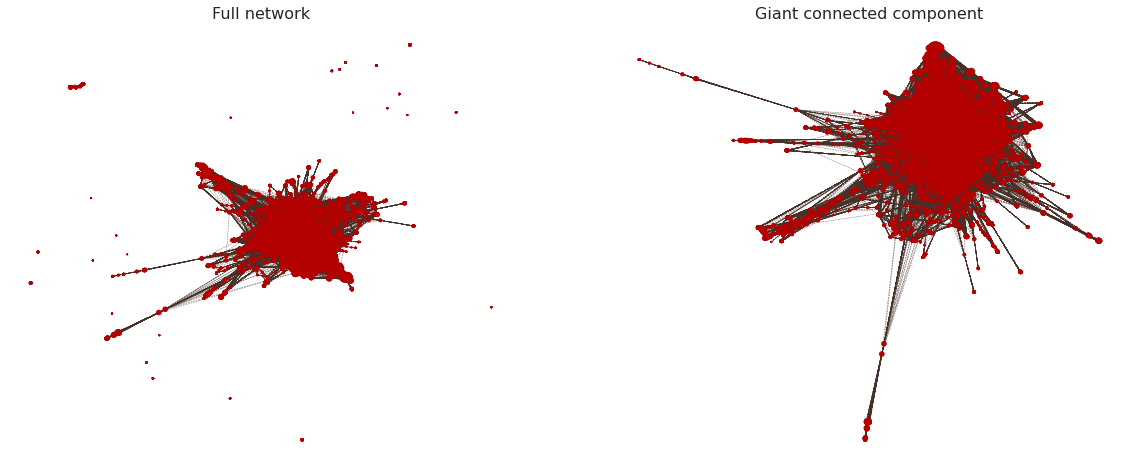

In [ ]:
m = 0.1
label_pos = {}
labels = {} 

plot_network(G_actors, GCC_actors, positions1, positions2,labels, label_pos, decade, m)

We observe that the network consists of one very large giant connected component and several small compoennts. 

# 3. Tools, theory and analysis

## Genre analysis

We now wish to dig further into the genres represented in the data set. It will be investigated how basic statistics such as cast size and budget differ within the genres. Furthermore, the genres will be characterized based on a text analysis of the plot synopses and key words of the movies within the genres. During the analysis, we will keep in mind that a movie is usually characterized with several different genres. Therefore, the movies can not be divided into non-overlapping groups representing the different genre, and the statistics and plot synopsis of a movie will therefore most likely be used to describe several of the genres. 

A total of 21 genres are represented in the dataset. The 9 most represented genres (i.e. the genres which the higest number of movies characterized with the genre) are selected for further analysis.

In [ ]:
df_genre = pd.DataFrame(columns = ["Genre", "Number of movies"])
df_genre["Genre"] = [name.replace("MovieIDs_", "") for name in df_actors.columns if "MovieIDs_" in name and "0" not in name]
df_genre["Number of movies"] = None

for idx, row in df_genre.iterrows():
  df_genre.loc[idx]["Number of movies"] = len(df_movies[df_movies["Genres"].apply(lambda x : row["Genre"] in x)])

df_genre.sort_values(by = "Number of movies", ascending = False, inplace = True)

In [ ]:
num_select = 9

fig = go.Figure()
fig.add_trace(go.Bar(x=[genre.capitalize() for genre in df_genre['Genre'][:num_select]], y=df_genre['Number of movies'][:num_select], marker_color='#b30000', name = "Selected genres")) 
fig.add_trace(go.Bar(x=[genre.capitalize() for genre in df_genre['Genre'][num_select:]], y=df_genre['Number of movies'][num_select:], marker_color='#443028', name = "Discarded genres")) 
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.83), barmode='overlay', width=1184, height=500, xaxis = dict(title = 'Genre', tickangle = -90), yaxis_title_text='Number of movies', bargap=0.2, bargroupgap=0.05, plot_bgcolor = 'rgb(236, 229, 222)')
fig.update_traces(opacity=0.6)
fig.show()
fig.write_html(mount_path+"../Plots/GenreHistogramSelected.html")

The genres chosen for further analysis are: Drama, Thriller, Comedy, Crime, Action, Adventure, Romance, Mystery and Sci-Fi. 

In [ ]:
selected_genres = ["drama", "thriller", "comedy", "crime", "action", "adventure", "romance", "mystery", "sci-fi"]
df_selected_genres = df_genre[df_genre["Genre"].isin(selected_genres)].reset_index(drop = True)

### Popular actors

First it is investigated, which actors are most frequently used within the genres. For each genre the 3 actors who have appeared in most movies within the genres are found. 

In [ ]:
for genre in selected_genres: 
  temp_df = df_actors[["ActorName", "MovieIDs_"+genre]]
  temp_df["Len"] = temp_df["MovieIDs_"+genre].apply(lambda x : len(x))
  top3 = temp_df.sort_values(by = "Len", ascending = False)[:5].reset_index(drop=True)
  top3 = top3[:3][["ActorName"]]
  print("\n"+genre.capitalize())
  print(top3)


Drama
        ActorName
0  Robert De Niro
1       Al Pacino
2       Tom Hanks

Thriller
           ActorName
0  Samuel L. Jackson
1      Michael Caine
2       Bruce Willis

Comedy
           ActorName
0        Bill Murray
1  John Ratzenberger
2     Mickie McGowan

Crime
        ActorName
0  Robert De Niro
1       Al Pacino
2     Paul Herman

Action
       ActorName
0       Stan Lee
1  Harrison Ford
2    Zoe Saldana

Adventure
           ActorName
0  John Ratzenberger
1           Stan Lee
2        Sherry Lynn

Romance
        ActorName
0     Julie Delpy
1      Cary Grant
2  Audrey Hepburn

Mystery
       ActorName
0  David Bradley
1  Timothy Spall
2     Tom Felton

Sci-fi
            ActorName
0            Stan Lee
1  Scarlett Johansson
2         Zoe Saldana


The lists are dominated by actors of a certain age who have been in the game for a while, and who have had plenty of time to star in a lot of movies. With ages 33, 36 and 42, Tom Felton, Scarlett Johansson and Zoe Saldana are the youngest actors/actresses featured on the list. A quick investigation is now carried out to find out how these young actors made it to the list. 

**Tom Felton**

We take a look at the movies of the genre Mystery which Tom Felton has starred in. 

In [ ]:
tom_felton_mystery = np.concatenate(df_actors[df_actors["ActorName"] == "Tom Felton"]["MovieIDs_mystery"].values)
df_movies[df_movies["MovieID"].isin(tom_felton_mystery)]

MovieID  ...                                           Creators
200  tt1201607  ...                            [Steve Kloves, cchip96]
437  tt0304141  ...  [Steve Kloves, morf_enimsaj, Way to go, Harry ...
641  tt0926084  ...                            [Steve Kloves, neji107]
663  tt0330373  ...  [Steve Kloves, cosmic_quest, Good though rushe...
789  tt0417741  ...                          [Steve Kloves, pgtmatrix]

[5 rows x 21 columns]

In [ ]:
num_hp = len(df_movies[df_movies["Title"].str.contains("Harry Potter")])
print(f"Number of Harry Potter movies on the IMDB list: {num_hp}")

Number of Harry Potter movies on the IMDB list: 6

Main characters of Harry Potter
Daniel Radcliffe (Harry Potter)	 has starred in 5 within the mystery genre (5 of these are Harry Potter movies)
Emma Watson (Hermione Granger)	 has starred in 5 within the mystery genre (5 of these are Harry Potter movies)
Rupert Grint (Ron Weasley)	 has starred in 5 within the mystery genre (5 of these are Harry Potter movies)

Top 2 mystery actors
David Bradley has starred in 5 within the mystery genre (4 of these are Harry Potter movies)
Timothy Spall has starred in 5 within the mystery genre (5 of these are Harry Potter movies)


Clearly, Tom Felton is appearing on the list due to his regular role in the Harry Potter series, where 6 out of the 8 movies are appearing on the 
list of the movies with highest user ratings on IMDB, and 5 of these are characterized as Mystery. We now take a look at the three main characters of Harry Potter along with the actors who are on the top 2 of the mystery list.

In [ ]:
print("Main characters of Harry Potter")
main_actors_hp = ["Daniel Radcliffe", "Emma Watson", "Rupert Grint"]
characters = ["Harry Potter", "Hermione Granger", "Ron Weasley"]
for idx, actor in enumerate(main_actors_hp): 
  movie_ids = np.concatenate(df_actors[df_actors["ActorName"] == actor]["MovieIDs_mystery"].values)
  temp_df = df_movies[df_movies["MovieID"].isin(movie_ids)]
  num_movies = len(temp_df)
  num_hp_movies = len(temp_df[temp_df["Title"].str.contains("Harry Potter")])
  print(f"{actor} ({characters[idx]})\t has starred in {num_movies} within the mystery genre ({num_hp_movies} of these are Harry Potter movies)")

print("\nTop 2 mystery actors")
other_mystery_actors = ["David Bradley","Timothy Spall"]
for actor in other_mystery_actors: 
  movie_ids = np.concatenate(df_actors[df_actors["ActorName"] == actor]["MovieIDs_mystery"].values)
  temp_df = df_movies[df_movies["MovieID"].isin(movie_ids)]
  num_movies = len(temp_df)
  num_hp_movies = len(temp_df[temp_df["Title"].str.contains("Harry Potter")])
  print(f"{actor} has starred in {num_movies} within the mystery genre ({num_hp_movies} of these are Harry Potter movies)")

Main characters of Harry Potter
Daniel Radcliffe (Harry Potter)	 has starred in 5 within the mystery genre (5 of these are Harry Potter movies)
Emma Watson (Hermione Granger)	 has starred in 5 within the mystery genre (5 of these are Harry Potter movies)
Rupert Grint (Ron Weasley)	 has starred in 5 within the mystery genre (5 of these are Harry Potter movies)

Top 2 mystery actors
David Bradley has starred in 5 within the mystery genre (4 of these are Harry Potter movies)
Timothy Spall has starred in 5 within the mystery genre (5 of these are Harry Potter movies)


We see that the three main actors of Harry Potter (and probably most of the other regular actors) have starred in as many movies within the mystery genre as Tom Felton and the other two actors who made it on the list. Furthermore, it is discovered that the two other actors are both featured in most of the Harry Potter movies as well. Thus this list does not represent actors who are used more frequently within the mystery genre than their colleagues, but instead it represent three actors who are selected more or less randomly from a large group of actors who have starred in a series of very popular movies within the mystery genre. 

**Zoe Saldana**

We now take a look at the movies within the genres Sci-fi and Action which features Zoe Saldana. 

In [ ]:
zoe_saldana = list(np.concatenate(df_actors[df_actors["ActorName"] == "Zoe Saldana"]["MovieIDs_sci-fi"].values)) + list(np.concatenate(df_actors[df_actors["ActorName"] == "Zoe Saldana"]["MovieIDs_action"].values))
df_movies[df_movies["MovieID"].isin(zoe_saldana)]

MovieID  ...                                           Creators
54   tt4154796  ...  [Christopher Markus, Stephen McFeely, Stan Lee...
55   tt4154756  ...  [Christopher Markus, Stephen McFeely, Stan Lee...
298  tt2015381  ...  [James Gunn, Nicole Perlman, Dan Abnett, Andy ...
330  tt0325980  ...  [Ted Elliott, Terry Rossio, Stuart Beattie, Ja...
427  tt0796366  ...  [Roberto Orci, Alex Kurtzman, Gene Roddenberry...
528  tt0499549  ...                           [James Cameron, Fjalar_]
632  tt1408101  ...  [Roberto Orci, Alex Kurtzman, Damon Lindelof, ...
751  tt3896198  ...  [James Gunn, Dan Abnett, Andy Lanning, Steve E...

[8 rows x 21 columns]

Apparently many of the films from the Marvel Cinematic Universe are among the highest user-rated movies on IMDB. The fact that Zoe Saldana has a recurring role in these movies, helps placing her on the list. 

**Scarlett Johansson**

We now take a look at the movies within the genres Sci-fi genre featuring Scarlett Johansson. 

In [ ]:
scarlett_johansson = np.concatenate(df_actors[df_actors["ActorName"] == "Scarlett Johansson"]["MovieIDs_sci-fi"].values)
df_movies[df_movies["MovieID"].isin(scarlett_johansson)]

MovieID  ...                                           Creators
35   tt0482571  ...  [Jonathan Nolan, Christopher Nolan, Christophe...
54   tt4154796  ...  [Christopher Markus, Stephen McFeely, Stan Lee...
55   tt4154756  ...  [Christopher Markus, Stephen McFeely, Stan Lee...
300  tt1798709  ...                         [Spike Jonze, monkyman347]
314  tt0848228  ...  [Joss Whedon, Zak Penn, Joss Whedon, MR_Heracl...
404  tt5104604  ...  [Wes Anderson, Roman Coppola, Jason Schwartzma...
493  tt3498820  ...  [Christopher Markus, Stephen McFeely, Joe Simo...
624  tt1843866  ...  [Christopher Markus, Stephen McFeely, Joe Simo...

[8 rows x 21 columns]

Similarly to Zoe Saldana, it is clearly Scarlett Johansson's recurring role of the Black Widow in the Marvel Cinematic Universe, which helps place her on the list. 

### Statistics within each genre

For each genre, the following statistics are now computed based on the movies within the genre: 



*   Average budget
*   Average age of main cast
*   Average sentiment score of the plot synopses and key words of the movies
*   Average size of the main cast



In [ ]:
# Average budget
def find_average_budget(genre):
  df_temp = df_movies[df_movies["Genres"].apply(lambda x : genre in x)]

  return df_temp["Budget"].mean()


# Average age
def find_average_age(genre):
  df_temp = df_movies[df_movies["Genres"].apply(lambda x : genre in x)]
  ages = []

  for idx, row in df_temp.iterrows():
    release_year = row["ReleaseYear"]
    birthdays = df_actors[df_actors["ActorID"].isin(row["ActorIDs"])]["Birthday"].values

    ages += [release_year - int(bd[:4]) for bd in birthdays if bd is not None]


  return np.mean(ages), np.std(ages)

# Average sentiment score
def find_average_sentiment_score(genre):
  df_temp = df_movies[df_movies["Genres"].apply(lambda x : genre in x)]

  return df_temp["AverageSentiment"].mean()

# Average main cast size
def find_average_main_cast_size(genre):
  df_temp = df_movies[df_movies["Genres"].apply(lambda x : genre in x)]
  sizes = df_temp["ActorIDs"].apply(lambda x : len(x))

  return np.mean(sizes)

In [ ]:
df_selected_genres["Average budget"] = df_selected_genres["Genre"].apply(lambda x : find_average_budget(x))
df_selected_genres["Average actor age"], df_selected_genres["Std actor age"] = zip(*df_selected_genres["Genre"].apply(lambda x : find_average_age(x)))
df_selected_genres["Average sentiment score"] = df_selected_genres["Genre"].apply(lambda x : find_average_sentiment_score(x))
df_selected_genres["Average main cast size"] = df_selected_genres["Genre"].apply(lambda x : find_average_main_cast_size(x))

The statistics are visualized in the following plot. Note that it is possible to hover the mouse over a bar to see which genre it represents.

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=2, cols=2, subplot_titles=("Budget", "Age", "Sentiment", "Cast size"))
fig.update_layout(barmode='overlay', width=1184, height=700, bargap=0.2, bargroupgap=0.05, plot_bgcolor = 'rgb(236, 229, 222)')

colors = ['#b30000', '#443028', '#cd6700', '#cfbdb1', '#b29582', '#cfb1b4', '#b28286', '#674c4c', '#9a4d00']

df_budget = df_selected_genres.sort_values(by = "Average budget", ascending = False).reset_index(drop = True)
df_age = df_selected_genres.sort_values(by = "Average actor age", ascending = False).reset_index(drop = True)
df_sent = df_selected_genres.sort_values(by = "Average sentiment score", ascending = False).reset_index(drop = True)
df_size = df_selected_genres.sort_values(by = "Average main cast size", ascending = False).reset_index(drop = True)

for idx, row in df_selected_genres.iterrows(): 
  color = colors[idx]

  idx_budget = df_budget[df_budget["Genre"] == row["Genre"]].index[0]
  idx_age = df_age[df_age["Genre"] == row["Genre"]].index[0]
  idx_sent = df_sent[df_sent["Genre"] == row["Genre"]].index[0]
  idx_size = df_size[df_size["Genre"] == row["Genre"]].index[0]

  # Budget
  fig.add_trace(go.Bar(x = [idx_budget], y=[row['Average budget']], marker_color=color, name = row["Genre"].capitalize()), row = 1, col = 1)

  # Age
  fig.add_trace(go.Bar(x = [idx_age], y=[row['Average actor age']], marker_color=color, name = row["Genre"].capitalize(), showlegend=False), row=1, col=2)

  # Sentiment
  fig.add_trace(go.Bar(x = [idx_sent], y=[row['Average sentiment score']], marker_color=color, name = row["Genre"].capitalize(), showlegend=False), row=2, col=1)

  # Cast size
  fig.add_trace(go.Bar(x = [idx_size], y=[row['Average main cast size']], marker_color=color, name = row["Genre"].capitalize(), showlegend=False), row=2, col=2)

fig.update_xaxes(title_text="Genre", row=1, col=1, showticklabels = False)
fig.update_yaxes(title_text="Average budget [$]", row=1, col=1)
fig.update_xaxes(title_text="Genre", row=1, col=2, showticklabels = False)
fig.update_yaxes(title_text="Average cast age", row=1, col=2)
fig.update_xaxes(title_text="Genre", row=2, col=1, showticklabels = False)
fig.update_yaxes(title_text="Average sentiment score", row=2, col=1)
fig.update_xaxes(title_text="Genre", row=2, col=2, showticklabels = False)
fig.update_yaxes(title_text="Average cast size", row=2, col=2)


fig.update_traces(opacity=0.8)
fig.show()
fig.write_html(mount_path+"../Plots/GenreStatistics.html")

**Budget** 

Adventure, sci-fi and action are by far the genres where the movie production is most expensive. On average it costs twice as much to produce a movie within these genres than within the remaining 6 genres. The differences are probably caused by the large expenses for special effects and stunt scenes which are often present in adventure, sci-fi and action movies.


**Age of cast**

The difference in the average age of the cast within the genres is surprisingly small; most likely the group of actors present in a genre is so large, that the number more or less reflects the average age in the data set. In order to get an impression of which genre uses e.g. the most child actors, it would be necessary to take a closer look at the specific movies within each genre, or to 
look at the distribution of specific age groups within the genres.


**Sentiment score**

Based on the average sentiment scores, the happiest genres are romance, comedy and drama and the saddest genres are action, crime and thriller. This corresponds very well to the common perception of the genres.


**Size of main cast**

We see a difference in the average size of the main cast in movies within the genres. The genres action, crime and sci-fi tend to have the largest main cast and the genres romance, comedy and mystery tend to have the smallest. These trend make intuitive sense, since e.g. an action movie often have many scenes with a large number of roles, such as fight scenes or scenes reflecting political events. On the other hand, a romantic comedy will often revolve around a small group of characters and the relations between them. 

### Text analysis

Finally, we want to get an impression of the elements and topics which characterises movie plots of each genre. We base this on a text analysis performed on the plot synopses and the list of keywords for the movies within the genres, with the result of the analysis displayed as word clouds. 

First a document is created for each genre containing the tokens of the (cleaned) plot synopses and key words (the attribute `Document` from the movies `DataFrame`) for all movies within the genre. 

In [ ]:
def extract_document(genre):
  df_temp = df_movies[df_movies["Genres"].apply(lambda x : genre in x)]
  document = np.concatenate(df_temp["Document"].values)

  return document

df_selected_genres["Documents"] = df_selected_genres["Genre"].apply(lambda x : extract_document(x))

The goal is to have the word clouds display the topic and elements which best describe the unique topics and elements of the genre. We would therefore like to prioritize words which are mostly used to describe the plot of one genre or of a few genres, while we are not that interested in displaying words which are frequently used to describe the plots of all genres. 

We therefore assign a weight to each word within each genre using a TF-IDF approach. First, the number of times a word appears in the document of each genre is counted. This number is called the term frequency (TF) of the word in the document. For each word it is also counted how many of the documents the word appears in (the column `Counts`). 

In [ ]:
tf_df = pd.DataFrame()

for idx, row in df_selected_genres.iterrows(): 
    freqdist = nltk.FreqDist(row["Documents"])
    temp_df = pd.DataFrame.from_dict(data = freqdist, orient = 'index', columns = [row["Genre"].capitalize()])
    tf_df = tf_df.join(temp_df, how='outer')

tf_df['Counts'] = tf_df.count(axis = 1)    
tf_df.fillna(value = 0, inplace = True)    
tf_df.loc[["love", "shot", "space"]]

Drama  Thriller  Comedy  Crime  ...  Romance  Mystery  Sci-fi  Counts
love   1224.0     329.0   425.0  196.0  ...    715.0    225.0   188.0       9
shot   1625.0    1175.0   307.0  932.0  ...    179.0    342.0   460.0       9
space   218.0     111.0    79.0    3.0  ...     18.0     27.0   385.0       9

[3 rows x 10 columns]

For each word we now compute a scaling factor. The use of the scaling factor is based on the idea that a word appearing in all documents might not contain much information about the specific genres. Therefore, the TFs of words appearing in all documents should be scaled down, while the TFs of words appearing in fewer documents should be scaled up. The scaling factor is computed as the smooth inverse document frequency (IDF) which is given by: 

$IDF_{word} = \log \left( \frac{N}{n_t+1} \right) + 1$

where $N = 9$ is the number of documents and $n_t$ is the number of documents containing the word. 

Source: https://en.wikipedia.org/wiki/Tf–idf

In [ ]:
tf_df['IDF'] = np.log(num_select/(tf_df['Counts'] + 1) + 1)
tf_df.sort_values(by = ["IDF"], ascending = False).head()

Drama  Thriller  Comedy  Crime  ...  Mystery  Sci-fi  Counts       IDF
bedding       1.0       0.0     0.0    0.0  ...      0.0     0.0       1  1.704748
rajah         0.0       0.0     0.0    0.0  ...      0.0     0.0       1  1.704748
histrionic    1.0       0.0     0.0    0.0  ...      0.0     0.0       1  1.704748
raliies       1.0       0.0     0.0    0.0  ...      0.0     0.0       1  1.704748
ralphie       0.0       0.0    55.0    0.0  ...      0.0     0.0       1  1.704748

[5 rows x 11 columns]

To get an impression of the weights, the 10 highest rated words for each genre are displayed.

In [ ]:
weights_df = pd.DataFrame()
for idx, row in df_selected_genres.iterrows():
    genre = row["Genre"].capitalize()
    weights_df[genre] = tf_df[genre]*tf_df['IDF']
    print(f'\nThe 10 highest weighted words for {genre}:')
    print(weights_df[genre].sort_values(ascending = False).index[:10].to_list())


The 10 highest weighted words for Drama:
['tell', 'one', 'man', 'reference', 'go', 'relationship', 'back', 'get', 'take', 'woman']

The 10 highest weighted words for Thriller:
['tell', 'police', 'man', 'one', 'car', 'back', 'go', 'shot', 'get', 'find']

The 10 highest weighted words for Comedy:
['reference', 'tell', 'back', 'one', 'go', 'man', 'get', 'take', 'car', 'relationship']

The 10 highest weighted words for Crime:
['police', 'tell', 'man', 'car', 'one', 'go', 'shot', 'get', 'back', 'take']

The 10 highest weighted words for Action:
['man', 'one', 'tell', 'car', 'back', 'shot', 'character', 'death', 'police', 'take']

The 10 highest weighted words for Adventure:
['back', 'character', 'one', 'man', 'tell', 'find', 'take', 'get', 'go', 'death']

The 10 highest weighted words for Romance:
['reference', 'relationship', 'love', 'one', 'tell', 'go', 'woman', 'man', 'back', 'time']

The 10 highest weighted words for Mystery:
['man', 'police', 'one', 'tell', 'go', 'woman', 'find', 'say

We see that the words "tell" and "one" are among the top 10 highest rated words for all genres. Based on this observation, we carry out a final filtering of the words, as a further step towards prioritizing words which are more unique and therefore more descriptive of the genre. 

The filtering is iterative. In each iteration, words appearing among the top 10 highest rated words for more than 80% of the genres, are added to a list of words which should be ignored in the word clouds. After the removal the 10 new highest rated words are computed for each genre, and the process is continued until no word appears in more than 80% of the top 10 highest rated words for each genre.

In [ ]:
additional_stopwords = []
weigts_df_for_stopwords = weights_df.copy()
done = False
it = 0
max_it = 50
percentage = 0.8

while not done and it < max_it:
  it += 1 
  top10 = [weigts_df_for_stopwords[genre.capitalize()].sort_values(ascending = False).index[:10].to_list() for genre in selected_genres]
  words, counts = np.unique(np.concatenate(top10), return_counts = True)
  common_words = words[counts > percentage*num_select]
  if len(common_words) < 1: 
    done = True
  else:
    weigts_df_for_stopwords = weigts_df_for_stopwords[~weigts_df_for_stopwords.index.isin(common_words)]
    additional_stopwords += list(common_words)

print(f"Number of iterations {it}")
print("Words to be ignored: ")
print(additional_stopwords)

Number of iterations 7
Words to be ignored: 
['back', 'man', 'one', 'tell', 'get', 'go', 'take', 'car', 'woman', 'find', 'time', 'reference', 'see', 'two', 'say']


The filtering did 7 iterations and resulted in the removal of the words back, man, one, tell, get, go, take, car, woman, find, time, reference, see, two and say. All the words seems reasonable to remove without too much loss of information.

For each genre one long string is now created. The string contains repetitions of the words; each word is repeated for a number of times corresponding to the weight of the word. 

In [ ]:
df_selected_genres["WordCloudText"] = None

for idx1, row1 in df_selected_genres.iterrows(): 
    words = []
    for idx2, row2 in weights_df.iterrows():
        for i in range(0, int(np.ceil(row2[row1["Genre"].capitalize()]))):
            words.append(idx2)   
            
    df_selected_genres["WordCloudText"][idx1] = ' '.join(words)

With these strings, the word clouds can now be computed and displayed. 

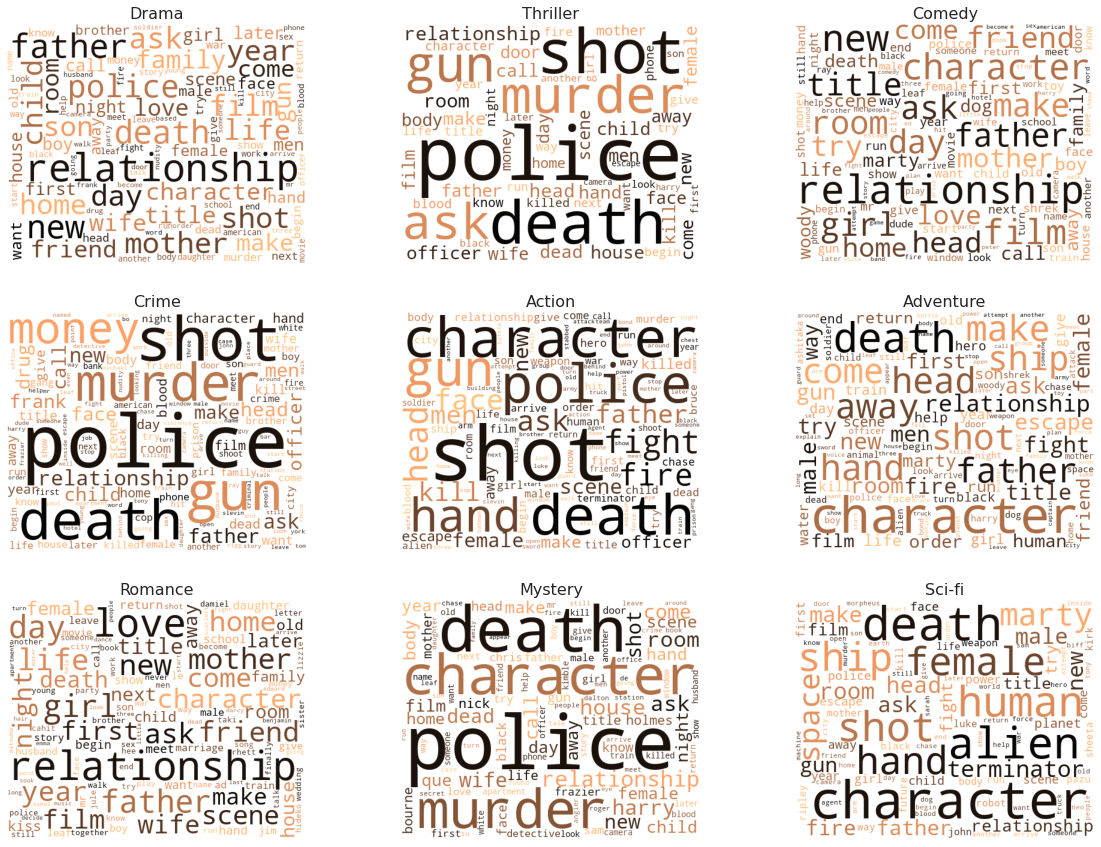

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

for word in additional_stopwords:
  stopwords.add(word)

fig, axs = plt.subplots(3,3, figsize=(20, 15))

x_index = 0 
y_index = 0
for idx, row in df_selected_genres.iterrows():
    wordcloud = WordCloud(background_color ='white', 
                    stopwords = stopwords, 
                    width = 500,
                    height = 400,
                    colormap = 'copper', 
                    min_font_size = 10, random_state = 42, collocations = False).generate(row["WordCloudText"])                        
    axs[x_index][y_index].imshow(wordcloud) 
    axs[x_index][y_index].axis("off") 
    axs[x_index][y_index].set_title(row["Genre"].capitalize(), fontsize = 16)
    if y_index != 2: 
        y_index += 1
    else: 
        x_index += 1
        y_index = 0
  
plt.show()
fig.savefig(mount_path+"../Plots/GenreWordClouds.png", bbox_inches = "tight")

The obtained word clouds seem to describe the genres well. We see that words such as "police", "gun", "death" and "shot" are used frequently to describe the plot of movies within the genres Thriller, Action, Crime and Mystery. This corresponds very well to the generel expections to movies of these genres. For the Sci-Fi genre some of the frequently used words are "human", "alien" and "space", indicating that movies of this genre are often revolving around space and intelligent life on other planets. For both Sci-Fi and Adventure some of the words overlap with the words seen in the word clouds of the genres Thriller and Action. Since a movie is usually characterised with at least two different genres, this indicates that Sci-Fi and Adventure movies often fall within the Thriller or Action genres as well. For the Romance genre the most frequently used words are - non surprisingly - "love" and "relationship". We also see a frequent use of words describing personal relations, such as "mother", "father", "brother", "wife", "friend" etc. This indicate that movies within this genre often have plots taking place in the everyday-life of the characters. A lot of the same words are used frequently to describe the plots of movies within the comedy genre, reflecting the fact that these two genres are known to overlap in the sub genre "Romantic comedy". Finally, for the Drama genre we see that the frequently used words overlap both with the Romance/Comedy genre but also with the Crime/Mystery genre. Thus Drama is potentially a genre which combines the themes of the every-day life with some more crime-related themes such as murder or kidnapping.

## Communities

We now use the Louvain method to find the best partition into communities of the full graph. This method aims to find the best partition by optimizing the modularity of the partition. The modularity is a measure of the quality of the division. For a graph with weighted edges it is computed as:
$$Q = \dfrac{1}{2m}\sum_{ij}\left[A_{ij} - \dfrac{k_i k_j}{2m}\right] \delta(c_i, c_j)$$

where $A_{ij}$ is the edge weight of the edge between the nodes $i$ and $j$, $k_i$ and $k_j$ are the sum of the weights of the edges attached to nodes $i$ and $j$ respectively, $m$ is the sum of all the edge weights in the graph, $c_i$ and $c_j$ are communities which the nodes $i$ and $j$ has been assigned to and $\delta$ is the Kronecker delta function, which is 1 if $c_i = c_j$ and 0 otherwise. 

The modularity measures whether there are fewer links between the communities than you would expect at random, and the higher the modularity the better the partition.

Since it would be too time consuming and computationally expensive to iterate through all possible partitions in order to find the partition with the optimal modularity, the Louvain method uses heuristics to find a good partition: It starts by finding small communities by optimizing the modularity locally on all nodes. Next, each of the small communities is considered as one node and the two steps are repeated until a good partition has been found. 

Source: https://en.wikipedia.org/wiki/Louvain_method)

Note that the description of the Louvain method has partially been re-used from the description we wrote in Assignment 2, however with some changes, since we are now working with a graph with weighted edges which was not the case in Assignment 2.

In [ ]:
G = pickle.load(open('/content/drive/MyDrive/02805 Social Graphs Assignments/Project Assignment/Graphs/large_graphNEW.txt', "rb"))

In [ ]:
partition = community.best_partition(G)

print(f'Modularity of the partition: {round(community.modularity(partition,G),2)}')
print(f'Number of communities in partition: {len(np.unique(list(partition.values())))}')

Modularity of the partition: 0.83
Number of communities in partition: 88


The found partition has 88 communities and a modularity of 0.83. In order to get an impression of the partition, the sizes of each community are now plotted along with the distribution of the community sizes. The size of a community is given by the number of members (actors) in the community. 

In [ ]:
all_communities, community_counts = np.unique(list(partition.values()), return_counts = True)
hist, bin_edges = np.histogram(community_counts, 100)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = [bin_edge + 0.5*bin_width for bin_edge in bin_edges[:-1]]

fig = go.Figure()
fig = make_subplots(rows=2, cols=1, subplot_titles=("Community sizes", "Distribution of community sizes"))
fig.add_trace(go.Bar(x=all_communities, y=community_counts, marker_color='#b30000', name = "Community size", showlegend = False), row = 1, col = 1) 
fig.add_trace(go.Bar(x=bin_centers, y=hist, marker_color='#b30000', name = "Number of communities in bin", showlegend = False), row = 2, col = 1) 
fig.update_layout(barmode='overlay', width=1184, height=700, bargap=0.2, bargroupgap=0.05, plot_bgcolor = 'rgb(236, 229, 222)')
fig.update_traces(opacity=0.6)
fig.update_yaxes(title_text="Number of members", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
fig.update_xaxes(title_text="Community", row=1, col=1)
fig.update_xaxes(title_text="Community size", row=2, col=1)
fig.show()

20 of the communities have rather few members, while a large number of the communities have between 100 and 500 members. Only 5 communities have more than 1000 members. We will now take a look at these 5 largest communities to see if we can figure out whether we can connect the communities in the graph to actual communities in the real world.

First the communities are added to the actors `DataFrame`. 

In [ ]:
df_partition = pd.DataFrame.from_dict(partition, orient = 'index', columns = ['Community'])
df_actors = pd.merge(df_actors, df_partition, left_on='ActorID', right_index=True)
df_actors.to_json(mount_path+'actors_dataframe_FINAL_with_communities.json')

The 5 largest communities are then extracted.

In [ ]:
num_select = 5
df_actors['Degree'] = [d for n, d in G.degree(df_actors['ActorID'])]
largest_communities = np.argsort(-community_counts)[:num_select]

df_communities = pd.DataFrame(columns = ['Number'], data = largest_communities)

For each community we now find: 

*   The number of members in the community
*   The three actors within the community with the highest degree
*   The number of movies represented in the community (i.e. the movies which feature the actors of the community)
*   The three most represented movies in the community (i.e. the movies which feature the highest number of actors from the community)

The communities are furthermore renamed from 1 to 5 with 1 being the largest community. 



In [ ]:
def find_actors_with_high_degree(com):
  return ', '.join(df_actors[df_actors['Community'] == com].sort_values(by = 'Degree', ascending = False)['ActorName'][0:3])

def find_number_of_members(com):
  return len(df_actors[df_actors["Community"] == com])

def find_number_of_movies(com):
  temp_df = df_actors[df_actors["Community"] == com]
  movies = np.unique(np.concatenate(temp_df["MovieIDs"].values))

  return len(movies)

def find_most_represented_movies(com):
  temp_df = df_actors[df_actors["Community"] == com]
  movies, counts = np.unique(np.concatenate(temp_df["MovieIDs"].values), return_counts = True)
  movie_ids = movies[np.argsort(-counts)[:3]]

  return ', '.join(df_movies[df_movies["MovieID"].isin(movie_ids)]["Title"].to_list())

In [ ]:
df_communities["Name"] = [1,2,3,4,5]
df_communities["Number of members"] = df_communities["Number"].apply(lambda x : find_number_of_members(x))
df_communities["Actors with high degree"] = df_communities["Number"].apply(lambda x : find_actors_with_high_degree(x))
df_communities["Number of unique movies"] = df_communities["Number"].apply(lambda x : find_number_of_unique_movies(x))
df_communities["Most represented movies"] = df_communities["Number"].apply(lambda x : find_most_represented_movies(x))
display(df_communities)

Number  ...                            Most represented movies
0       2  ...  All the President's Men, All That Jazz, The Te...
1      52  ...                    PK, Special 26, My Name Is Khan
2      10  ...  Spirited Away, Spider-Man: Into the Spider-Ver...
3      17  ...  Harry Potter and the Deathly Hallows: Part 2, ...
4      27  ...                   Goodfellas, Casino, The Irishman

[5 rows x 6 columns]

Just from this quick overview, some possible tendencies are already visible; judging from the names of the actors of community 2 this community could represent the Indian movie industry. In community 3 the three most represented movies are all cartoons and since both John Ratzenberger and Sherry Lynn are voice actors frequently used by Disney, this community could represent the animated movie industry. Finally, both the three actors and the three movies shown for community 4 are British, so this community might represent the British movie industry.

We now dig further into the actors placed in the communities and into the genres, decades and countries which are represented in the communities through the actors. 

### Time analysis

First, we investigate whether any of the communities could represent a specific time period. For each community the minimum, maximum and average birth years of the actors within the community are found. Furthermore, the minimum, maximum and average release year of the movies represented in the community are found. The results are displayed in the plots below. 

In [ ]:
def release_year_analysis(com):
  years = []
  df_temp_a = df_actors[df_actors["Community"] == com]
  movie_ids = np.unique(np.concatenate(df_temp_a["MovieIDs"].values))
  df_temp = df_movies[df_movies["MovieID"].isin(movie_ids)]
  for idx, row in df_temp.iterrows():
    years.append(row["ReleaseYear"])

  return np.min(years), np.max(years), np.mean(years)

def birth_year_analysis(com):
  years = []
  df_temp = df_actors[df_actors["Community"] == com]
  for idx, row in df_temp.iterrows():
    if row["Birthday"]:
      years.append(datetime.strptime(row["Birthday"], '%Y-%m-%d').year)

  return np.min(years), np.max(years), np.mean(years)

In [ ]:
df_communities["Min release year"], df_communities["Max release year"], df_communities["Avg release year"] = zip(*df_communities["Number"].apply(lambda x : release_year_analysis(x)))
df_communities["Min birth year"], df_communities["Max birth year"], df_communities["Avg birth year"] = zip(*df_communities["Number"].apply(lambda x : birth_year_analysis(x)))

In [ ]:
red_color = "#b30000"
brown_color = "#443028"
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Movie release year", "Actor birth year"))
fig.update_layout(width=1184, height=500, plot_bgcolor = 'rgb(236, 229, 222)')
for idx, row in df_communities.iterrows():
  if idx == 0: 
    fig.add_trace(go.Scatter(y = [row["Name"], row["Name"]], x=[row["Min release year"], row["Max release year"]], marker_color=brown_color, name = 'Range', marker_size = 10), row = 1, col = 1)
  else:
    fig.add_trace(go.Scatter(y = [row["Name"], row["Name"]], x=[row["Min release year"], row["Max release year"]], marker_color=brown_color, name = 'Range', marker_size = 10, showlegend=False), row = 1, col = 1)

fig.add_trace(go.Scatter(y = df_communities["Name"], x=df_communities["Avg release year"], marker_color=red_color, name = 'Average', mode = 'markers', marker_size = 20), row = 1, col = 1)

for idx, row in df_communities.iterrows():
  if idx == 0: 
    fig.add_trace(go.Scatter(y = [row["Name"], row["Name"]], x=[row["Min birth year"], row["Max birth year"]], marker_color=brown_color, name = 'Range', marker_size = 10, showlegend=False), row = 1, col = 2)
  else:
    fig.add_trace(go.Scatter(y = [row["Name"], row["Name"]], x=[row["Min birth year"], row["Max birth year"]], marker_color=brown_color, name = 'Range', marker_size = 10, showlegend=False), row = 1, col = 2)

fig.add_trace(go.Scatter(y = df_communities["Name"], x=df_communities["Avg birth year"], marker_color=red_color, name = 'Average', mode = 'markers', marker_size = 20, showlegend=False), row = 1, col = 2)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Community", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Community", row=1, col=2)

fig.update_traces(opacity=0.8)
fig.show()
fig.write_html(mount_path+"../Plots/CommunityYearAnalysis.html")

For communities 2-5 the tendencies are quite similar. However, community 1 is different. The actors of this community tend to be significantly older than the actors of the other communities. Although some new movies are represented in the community, we generally see that a lot of older movies are represented compared to the other communities. 

We now investigate the decades represented in the communities further. For each community the distribution of decades within the community is computed and visualised. For each decade, the distribution value is given by the number of movies represented in the community which was released in that decade divided by the total number of movies represented in the community. 

Furthermore, the representation of the decades within the communities is computed. For a decade, the representation within a community is computed as the number of movies released in this decade which are represented in the community divided by the total number of movies released in this decade. 

Note that it is possible to hover the mouse over a part of a bar, to see details about the decade distribution and representation.

In [ ]:
decades = [name.replace("MovieIDs_", "") for name in df_actors.columns if '0s' in name]

def decade_analysis(com, decade):
  df_temp = df_temp = df_actors[df_actors["Community"] == com]
  return len(np.unique(np.concatenate(df_temp["MovieIDs_"+decade].values)))

In [ ]:
for decade in decades: 
  df_communities[decade] = df_communities["Number"].apply(lambda x : decade_analysis(x, decade))

In [ ]:
decade_counts = [len(df_movies[df_movies["Decade"] == decade]) for decade in decades]

In [ ]:
red_color = "#b30000"
brown_color = "#443028"
colors = [''.join(['rgb(',str(x),', ',str(y),', ',str(z),')']) for (x,y,z) in sns.color_palette('OrRd',10)]

fig = go.Figure()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Decade distribution within community", "Decade representation within community"))
fig.update_layout(barmode='stack', width=1184, height=500, plot_bgcolor = 'rgb(236, 229, 222)')

for idx, decade in enumerate(decades): 
  fig.add_trace(go.Bar(x = df_communities["Name"], y=df_communities[decade]/df_communities["Number of unique movies"], marker_color=colors[idx], name = decade), row = 1, col = 1)

for idx, decade in enumerate(decades): 
  fig.add_trace(go.Bar(x = df_communities["Name"], y=df_communities[decade]/decade_counts[idx], marker_color=colors[idx], name = decade, showlegend = False), row = 1, col = 2)


fig.update_xaxes(title_text="Community", row=1, col=1)
fig.update_yaxes(title_text="Percentage", row=1, col=1)
fig.update_xaxes(title_text="Community", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=1, col=2)


fig.update_traces(opacity=0.8)
fig.show()
fig.write_html(mount_path+"../Plots/CommunityDecadeAnalysis.html")

It is clear that the decade distribution of community 1 is quite different compared to the other communities. More than 80% of the movies represented in this community were released before 1990. In all of the other four communities, more than 60% the represented movies were released in 1990 or later. 

If we take a look at the decade representation, we see that 90% of the movies released in the 1940s, 83% of the movies released in the 1950s and 82% of the movies released in the 1930s are represented in this community. More than half of the movies released in the 1920s, 1960s and 1970s are also represented in the community. For comparison, the highest representation of a "newer" decade is seen for the 1990s in community 5 where 37% of the movies released in this decade are represented. 

Based on this analysis, it seems like community 1 represents the community of the "old" movie industry. 


### Genre analysis

Next, it will be investigated whether any of the communities could represent a specific genre of movies. For this analysis, the three most common genres among the movies represented in each community are found. For each genre, it is computed how big a fraction of the movies represented in the community that are associated with that genre (left plot). It is furthermore computed how big a fraction of the movies associated with that genre that are represented in the community (right plot). 

In [ ]:
def genre_analysis(com):
  df_temp_a = df_actors[df_actors["Community"] == com]
  movie_ids = np.unique(np.concatenate(df_temp_a["MovieIDs"].values))
  df_temp = df_movies[df_movies["MovieID"].isin(movie_ids)]
  genres, genre_counts = np.unique(np.concatenate(df_temp["Genres"].values), return_counts = True)
  selected_genres = genres[np.argsort(-genre_counts)][:3]
  selected_genre_counts = genre_counts[np.argsort(-genre_counts)][:3]

  return tuple([selected_genres[i]+', '+str(selected_genre_counts[i]) for i in range(len(selected_genres))])

In [ ]:
df_communities["Genre 1"], df_communities["Genre 2"], df_communities["Genre 3"] = zip(*df_communities["Number"].apply(lambda x : genre_analysis(x)))

In [ ]:
red_color = "#b30000"
brown_color = "#443028"
color_dict = {}
genre_counts = {genre : len(df_movies[df_movies["Genres"].apply(lambda x : genre in x)]) for genre in list(np.unique(np.concatenate(df_movies["Genres"].values)))}
colors = [''.join(['rgb(',str(x),', ',str(y),', ',str(z),')']) for (x,y,z) in sns.color_palette('Reds_r',9)]

fig = go.Figure()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 3 genres in community", "Percentage of genre represented in community"))
fig.update_layout(barmode='stack', width=1184, height=500, plot_bgcolor = 'rgb(236, 229, 222)', bargap=0.02, bargroupgap=0.05)

next_color = 0
for idx, row in df_communities.iterrows():
  for i in range(3):
    showlegend = False
    genre, count = row["Genre "+str(i+1)].split(', ')
    if genre not in color_dict.keys():
      color_dict[genre] = colors[next_color]
      next_color += 1
      showlegend = True

    fig.add_trace(go.Bar(x = [row["Name"]], y=[int(count)/row["Number of unique movies"]], marker_color=color_dict[genre], showlegend = showlegend, name = genre), row = 1, col = 1)
    fig.add_trace(go.Bar(x = [row["Name"]], y=[int(count)/genre_counts[genre]], marker_color=color_dict[genre], showlegend = False, name = genre), row = 1, col = 2)


fig.update_xaxes(title_text="Community", row=1, col=1)
fig.update_yaxes(title_text="Percentage", row=1, col=1)
fig.update_xaxes(title_text="Community", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=1, col=2)


fig.update_traces(opacity=0.8)
fig.show()
fig.write_html(mount_path+"../Plots/CommunityGenreAnalysis.html")

From the left plot we see that in all 5 communities the most represented genre is Drama. This is no surprise given that Drama is by far the most represented genre in the Data set. Although only 33% of the movies represented in community 3 are associated with the genre Animation, we see on the right plot, that this actually corresponds to 84% of all movies associated with the genre. This observation supports the theory that community 3 may represent the animated movie industry. Other than that, none of the communities seems to be associated with specific any genre. 

### Country analysis

We now wish to investigate whether any of the communities could represent the movie industry of specific countries. First, the birth countries of the actors in the community are analysed. 

For each community, the three most common birth countries among the actors of the community are found, and it is computed how big a fraction of the actors in the community are born in each of the three countries (left plot). Since the birth country is unknown for many of the actors, the fraction is computed based on the actors in the community for whom we know the birth country rather than based on the total number of actors in the community. 

For each of the three most common birth countries, the representation of the birth country in the community is furthermore computed. This value is computed as the fraction of actors born in the specific country belonging to the specific community (right plot). 

In [ ]:
def birth_country_analysis(com):
  df_temp = df_actors[df_actors["Community"] == com]
  df_temp = df_temp[~df_temp["BirthCountry"].isna()]
  countries, country_counts = np.unique(df_temp["BirthCountry"].values, return_counts = True)
  selected_countries = countries[np.argsort(-country_counts)][:3]
  selected_country_counts = country_counts[np.argsort(-country_counts)][:3]

  return tuple([selected_countries[i]+', '+str(selected_country_counts[i]) for i in range(len(selected_countries))])

In [ ]:
df_communities["BirthCountry 1"], df_communities["BirthCountry 2"], df_communities["BirthCountry 3"] = zip(*df_communities["Number"].apply(lambda x : birth_country_analysis(x)))

In [ ]:
red_color = "#b30000"
brown_color = "#443028"
color_dict = {}
birth_country_counts = {country : len(df_actors[df_actors["BirthCountry"] == country]) for country in list(df_actors["BirthCountry"].unique()) if country is not None}
num_actor_with_birth_place = [df_actors[df_actors["Community"] == com]["BirthCountry"].count() for com in df_communities["Number"].values]
colors = [''.join(['rgb(',str(x),', ',str(y),', ',str(z),')']) for (x,y,z) in sns.color_palette('Reds_r',7)]

color_dict = {}
next_color = 0
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 3 birth countries in community", "Percentage of birth country represented in community"))
fig.update_layout(barmode='stack', width=1184, height=500, plot_bgcolor = 'rgb(236, 229, 222)', bargap=0.02, bargroupgap=0.05)
for idx, row in df_communities.iterrows():
  for i in range(3):
    showlegend = False
    country, count = row["BirthCountry "+str(i+1)].split(', ')
    if country not in color_dict.keys():
      color_dict[country] = colors[next_color]
      next_color += 1
      showlegend = True

    fig.add_trace(go.Bar(x = [row["Name"]], y=[int(count)/num_actor_with_birth_place[idx]], marker_color=color_dict[country], showlegend = showlegend, name = country), row = 1, col = 1)
    fig.add_trace(go.Bar(x = [row["Name"]], y=[int(count)/birth_country_counts[country]], marker_color=color_dict[country], showlegend = False, name = country), row = 1, col = 2)

fig.update_xaxes(title_text="Community", row=1, col=1)
fig.update_yaxes(title_text="Percentage", row=1, col=1)
fig.update_xaxes(title_text="Community", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=1, col=2)


fig.update_traces(opacity=0.8)
fig.show()
fig.write_html(mount_path+"../Plots/CommunityBirthCountryAnalysis.html")

In the communities 1, 3 and 5 more than 60% of the actors with known birth countries are born in USA. However, in community 2 and community 4 more than 80% of the actors with known birth place are born in India and the United Kingdom, respectively. However, from the representation plot (to the right) we see that only 60% of the actors born in India are in fact placed in community 2, while only 26% of the actors born in the United Kingdom are placed in community 4.

We now take a look at the release countries of the movies represented in the communities. For each community we find the three most common release countries. Similar to the analysis of the birth countries we then compute the fraction of movies represented in the community which were released in the specific country (left plot). We also compute how big a fraction of the movies released in the specific country that are represented in the community (right plot).

In [ ]:
def country_analysis(com):
  df_temp_a = df_actors[df_actors["Community"] == com]
  movie_ids = np.unique(np.concatenate(df_temp_a["MovieIDs"].values))
  df_temp = df_movies[df_movies["MovieID"].isin(movie_ids)]
  countries, country_counts = np.unique(df_temp["Country"].values, return_counts = True)
  selected_countries = countries[np.argsort(-country_counts)][:3]
  selected_country_counts = country_counts[np.argsort(-country_counts)][:3]

  return tuple([selected_countries[i]+', '+str(selected_country_counts[i]) for i in range(len(selected_countries))])

In [ ]:
df_communities["Country 1"], df_communities["Country 2"], df_communities["Country 3"] = zip(*df_communities["Number"].apply(lambda x : country_analysis(x)))

In [ ]:
red_color = "#b30000"
brown_color = "#443028"
color_dict = {}
country_counts = {country : len(df_movies[df_movies["Country"] == country]) for country in list(df_movies["Country"].unique())}
colors = [''.join(['rgb(',str(x),', ',str(y),', ',str(z),')']) for (x,y,z) in sns.color_palette('Reds_r',7)]

fig = go.Figure()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 3 release countries in community", "Percentage of release country represented in community"))
fig.update_layout(barmode='stack', width=1184, height=500, plot_bgcolor = 'rgb(236, 229, 222)', bargap=0.02, bargroupgap=0.05)

next_color = 0
for idx, row in df_communities.iterrows():
  for i in range(3):
    showlegend = False
    country, count = row["Country "+str(i+1)].split(', ')
    if country not in color_dict.keys():
      color_dict[country] = colors[next_color]
      next_color += 1
      showlegend = True

    fig.add_trace(go.Bar(x = [row["Name"]], y=[int(count)/row["Number of unique movies"]], marker_color=color_dict[country], showlegend = showlegend, name = country.replace("USA", "United States").replace("UK", "United Kingdom")), row = 1, col = 1)
    fig.add_trace(go.Bar(x = [row["Name"]], y=[int(count)/country_counts[country]], marker_color=color_dict[country], showlegend = False, name = country.replace("USA", "United States").replace("UK", "United Kingdom")), row = 1, col = 2)

fig.update_xaxes(title_text="Community", row=1, col=1)
fig.update_yaxes(title_text="Percentage", row=1, col=1)
fig.update_xaxes(title_text="Community", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=1, col=2)

fig.update_traces(opacity=0.8)
fig.show()
fig.write_html(mount_path+"../Plots/CommunityReleaseCountryAnalysis.html")

75% of the movies represented in community 2 were released in India, and in fact all movies released in India are represented in this community. For the remaining communities the most common release country is USA, however for community 4, 34% of the represented movies were released in the UK. Furthermore, we see that 51% of the movies released in the UK are represented in community 4. We also see that a third of the movies released in Japan are represented in community 3. Since Japan is known for making a lot of cartoons, this observation corresponds very well with the fact that this community was found to represent the animated movie industry during the analysis of genres. 

Based on the analysis of the release- and birth countries it seems that community 2 does in fact represent the Indian movie industry (or at least a part of it). Community 4 seems to represent a part of the British movie industry, however since only about half of the British actors in the data set are actually placed in this community, we must assume that other non-inspected communities may also represent different parts of the British movie industry. Or perhaps the remaining British actors are placed in communities which are tied together by other common attributes than the birth country. 

### Popularity analysis

Finally, we make a quick analysis of the degrees of the actors in each community. This is motivated by the fact that at least two of the actors with the highest degrees in community 5, Robert De Niro and Al Pacino, are very well known and have starred in a lot of movies over the years. Since we have not yet managed to find any way to characterize community 5, we therefore wish to investigate whether this could be a community of some of the actors of Hollywood who have been very active for many years and who thus will most likely have a high degree in the graph. 

For each community the minimum, maximum and average degree are computed. These are visualised in the plot below along with the degree distributions for each community. Note that the statistics have been computed based on the actual degree of the actors in the graph - not their degree in the sub graph corresponding to their community. 

In [ ]:
def degree_analysis(com):
  nodes = df_actors[df_actors["Community"] == com]["ActorID"].values
  degree_sequence = [d for (n,d) in G.degree(nodes)]

  return np.min(degree_sequence), np.max(degree_sequence), np.mean(degree_sequence), degree_sequence

In [ ]:
df_communities["Min degree"], df_communities["Max degree"], df_communities["Avg degree"], df_communities["Degree sequence"] = zip(*df_communities["Number"].apply(lambda x : degree_analysis(x)))

In [ ]:
red_color = "#b30000"
brown_color = "#443028"
fig = go.Figure()
fig = make_subplots(rows=2, cols=3, subplot_titles=("Degree statistics", "Degree distribution (com. 1)", "Degree distribution (com. 2)", "Degree distribution (com. 3)", "Degree distribution (com. 4)", "Degree distribution (com. 5)"))
fig.update_layout(width=1184, height=600, plot_bgcolor = 'rgb(236, 229, 222)')
row_count = 1
col_count = 2
for idx, row in df_communities.iterrows():
  hist, bin_edges = np.histogram(row["Degree sequence"], 50)
  bin_width = bin_edges[1] - bin_edges[0]
  bin_centers = [bin_edge + 0.5*bin_width for bin_edge in bin_edges[:-1]]
  if idx == 0: 
    showlegend = True
  else:
    showlegend = False
  fig.add_trace(go.Scatter(y = [row["Name"], row["Name"]], x=[row["Min degree"], row["Max degree"]], marker_color=brown_color, name = 'Range', marker_size = 10, showlegend=showlegend), row = 1, col = 1)
  if idx == 0: 
    fig.add_trace(go.Scatter(y = df_communities["Name"], x=df_communities["Avg degree"], marker_color=red_color, name = 'Average', mode = 'markers', marker_size = 20), row = 1, col = 1)
  fig.add_trace(go.Scatter(x = bin_centers, y=hist, marker_color = red_color, name = 'Degree sequence', showlegend=showlegend, mode = 'lines+markers'), row = row_count, col = col_count)
  fig.update_xaxes(title_text="Degree", row=row_count, col=col_count)
  fig.update_yaxes(title_text="Frequency", row=row_count, col=col_count)
  fig.update_xaxes(range=[0, 1500], row=row_count, col=col_count)
  if col_count == 3: 
    row_count = 2
    col_count = 1
  else:
    col_count += 1

fig.update_xaxes(title_text="Degree", row=1, col=1)
fig.update_yaxes(title_text="Community", row=1, col=1)
fig.update_yaxes(tickvals=[1,2,3,4,5], row = 1, col = 1)

fig.update_traces(opacity=0.8)
fig.show()
fig.write_html(mount_path+"../Plots/CommunityDegreeAnalysis.html")

The actors of community 5 do have a bit higher degree on average, than the actors in the remaining communities. We also see that the maximum degree occurring in this community is quite a lot higher than the maximum degrees occurring in the remaining communities. However, there still are quite a few members of community who has a quite low degree, and thus we can not conclude that the community is purely a group of well known and frequently used actors.

In summary it seems like the four largest communities can be characterized as follows:

*   Community 1: A community of actors starring in the "older" movies on the IMDB list
*   Community 2: A community of actors starring in the Indian movies on the IMDB list
*   Community 3: A community of actors "starring in" (putting voice to) the animated movies on the IMDB list
*   Community 4: A community of actors starring in the British movies on the IMDB list





## Decades

Now, we want to investigate how the network of actors have changed over time. To do so we look at the network for each decade and find the basic statistics, the degree distribution and plot the network. 

### Basic Statistics and degree distribution in decades

First, the basic statistics for each decade is found. This includes the number of nodes and edges, the minimum, maximum and average weight of the edges, the minimum, maximum and average degree of nodes, the number of connected components in the network and the number of nodes and edges in the giant connected components as well as the percentage this is out of the total network, together with the average shortest path in the giant connected component. Furtermore, the degree distribution for each decade is plotted both as a normal plot and with logarithmic axes. 

In [ ]:
decades = ['1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

for decade in decades:
  G_actors = pickle.load(open(mount_path+'../Graphs/graph_'+decade+'.txt', "rb"))
  GCC_actors = max([G_actors.subgraph(c).copy() for c in nx.connected_components(G_actors)], key=len)
  degree_sequence = sorted([d for n, d in G_actors.degree(weight='weight')], reverse=False)
  weights = [G_actors.get_edge_data(*e)['weight']  for e in G_actors.edges() if e[0]]
  print(decade)

  print("Basic statistics")
  print(f"Number of nodes: {G_actors.number_of_nodes()}")
  print(f"Number of edges: {G_actors.number_of_edges()}")

  print("\nWeights")
  print(f"Minimum weight: {min(weights)}")
  print(f"Maximum weight: {max(weights)}")
  print(f"Average weight: {round(np.mean(weights),2)}")

  print("\nDegree")
  print(f"Minimum degree: {min(degree_sequence)}")
  print(f"Maximum degree: {max(degree_sequence)}")
  print(f"Average degree: {round(np.mean(degree_sequence),2)}")


  print("\nConnected components")
  print(f"Number of connected components: {len([G_actors.subgraph(c).copy() for c in nx.connected_components(G_actors)])}")

  print("\nGiant connected component")
  print(f"Number of nodes: {GCC_actors.number_of_nodes()}, which is {round(GCC_actors.number_of_nodes()/G_actors.number_of_nodes()*100,1)} % of all nodes.")
  print(f"Number of edges: {GCC_actors.number_of_edges()}, which is {round(GCC_actors.number_of_edges()/G_actors.number_of_edges()*100,1)} % of all edges")
  print(f"Average shortest path length: {round(nx.average_shortest_path_length(GCC_actors),2)}")

  plot_degrees(decade, degree_sequence)

1920s
Basic statistics
Number of nodes: 77
Number of edges: 335

Weights
Minimum weight: 1
Maximum weight: 2
Average weight: 1.0

Degree
Minimum degree: 4
Maximum degree: 13
Average degree: 8.73

Connected components
Number of connected components: 8

Giant connected component
Number of nodes: 13, which is 16.9 % of all nodes.
Number of edges: 54, which is 16.1 % of all edges
Average shortest path length: 1.31


1930s
Basic statistics
Number of nodes: 207
Number of edges: 1427

Weights
Minimum weight: 1
Maximum weight: 2
Average weight: 1.01

Degree
Minimum degree: 5
Maximum degree: 36
Average degree: 13.88

Connected components
Number of connected components: 12

Giant connected component
Number of nodes: 68, which is 32.9 % of all nodes.
Number of edges: 585, which is 41.0 % of all edges
Average shortest path length: 2.36


1940s
Basic statistics
Number of nodes: 444
Number of edges: 5298

Weights
Minimum weight: 1
Maximum weight: 3
Average weight: 1.0

Degree
Minimum degree: 4
Maximum degree: 122
Average degree: 23.95

Connected components
Number of connected components: 4

Giant connected component
Number of nodes: 381, which is 85.8 % of all nodes.
Number of edges: 4337, which is 81.9 % of all edges
Average shortest path length: 2.97


1950s
Basic statistics
Number of nodes: 805
Number of edges: 14050

Weights
Minimum weight: 1
Maximum weight: 3
Average weight: 1.01

Degree
Minimum degree: 6
Maximum degree: 144
Average degree: 35.2

Connected components
Number of connected components: 6

Giant connected component
Number of nodes: 710, which is 88.2 % of all nodes.
Number of edges: 13205, which is 94.0 % of all edges
Average shortest path length: 3.95


1960s
Basic statistics
Number of nodes: 1136
Number of edges: 14529

Weights
Minimum weight: 1
Maximum weight: 3
Average weight: 1.02

Degree
Minimum degree: 3
Maximum degree: 115
Average degree: 26.0

Connected components
Number of connected components: 14

Giant connected component
Number of nodes: 821, which is 72.3 % of all nodes.
Number of edges: 9912, which is 68.2 % of all edges
Average shortest path length: 4.33


1970s
Basic statistics
Number of nodes: 2043
Number of edges: 47385

Weights
Minimum weight: 1
Maximum weight: 3
Average weight: 1.0

Degree
Minimum degree: 5
Maximum degree: 254
Average degree: 46.55

Connected components
Number of connected components: 11

Giant connected component
Number of nodes: 1741, which is 85.2 % of all nodes.
Number of edges: 43178, which is 91.1 % of all edges
Average shortest path length: 3.38


1980s
Basic statistics
Number of nodes: 3273
Number of edges: 105204

Weights
Minimum weight: 1
Maximum weight: 3
Average weight: 1.0

Degree
Minimum degree: 4
Maximum degree: 332
Average degree: 64.46

Connected components
Number of connected components: 9

Giant connected component
Number of nodes: 3046, which is 93.1 % of all nodes.
Number of edges: 100286, which is 95.3 % of all edges
Average shortest path length: 3.63


1990s
Basic statistics
Number of nodes: 5866
Number of edges: 244882

Weights
Minimum weight: 1
Maximum weight: 6
Average weight: 1.0

Degree
Minimum degree: 9
Maximum degree: 573
Average degree: 83.81

Connected components
Number of connected components: 9

Giant connected component
Number of nodes: 5584, which is 95.2 % of all nodes.
Number of edges: 240373, which is 98.2 % of all edges
Average shortest path length: 3.26


2000s
Basic statistics
Number of nodes: 9126
Number of edges: 307572

Weights
Minimum weight: 1
Maximum weight: 4
Average weight: 1.01

Degree
Minimum degree: 5
Maximum degree: 411
Average degree: 68.02

Connected components
Number of connected components: 13

Giant connected component
Number of nodes: 8330, which is 91.3 % of all nodes.
Number of edges: 290833, which is 94.6 % of all edges
Average shortest path length: 3.62


2010s
Basic statistics
Number of nodes: 8912
Number of edges: 321074

Weights
Minimum weight: 1
Maximum weight: 5
Average weight: 1.01

Degree
Minimum degree: 1
Maximum degree: 633
Average degree: 73.0

Connected components
Number of connected components: 18

Giant connected component
Number of nodes: 8372, which is 93.9 % of all nodes.
Number of edges: 308223, which is 96.0 % of all edges
Average shortest path length: 3.52


Overall the degree distributions do not appear to stricly follow any known distributions. Another observation is that the network from decade to decade becomes larger and larger, with the only exception being 2000s, which is larger than 2010s. The individual decades are further discussed together with the plots of the networks in the section *Discussion of decades*. 

### Plotting network in decades

Now the network in the respective decades are plotted. This is both done for the full network and for the giant connected component. For the giant connected component the three nodes with the highest degrees have been labeled with the name of the respective actors and their nodes have been positioned in seperate corners of the graph. In addition, the edges between nodes have been seperated into two groups; edges with a weight of 1, meaning that the actors have starred in one movie together, and edges with a weight of more than 1, meaning that the two actors have starred in more than one movie together. Edges with a weight of 1 is represented by a dashed, light brown line, while edges with a higher weight is represented by a solid, dark brown line. Furthermore, some basic statistics of the network in each decade is shown below the visualization of the network. Note, that movies that were released in 2020 have been included in the 2010s.

The networks from all the decades are plotted below, but since the positions are found with the Force Atlas2 algorithm and thereby is not fixed, each decade has also been run individually a number of times in order to obtain as good a visualization as possible. These plots are shown on the webpage https://network-of-actors.github.io/timeline.

100%|██████████| 2000/2000 [00:00<00:00, 42050.48it/s]


BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.20  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
1920s


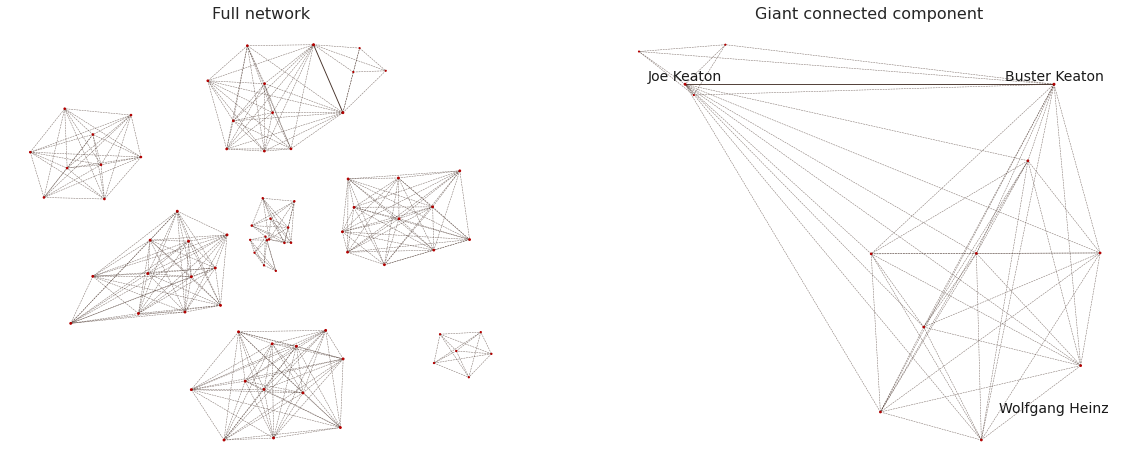

 27%|██▋       | 549/2000 [00:00<00:00, 5482.96it/s]

BarnesHut Approximation  took  0.58  seconds
Repulsion forces  took  0.75  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


100%|██████████| 2000/2000 [00:00<00:00, 6041.62it/s]


BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.12  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds
1930s


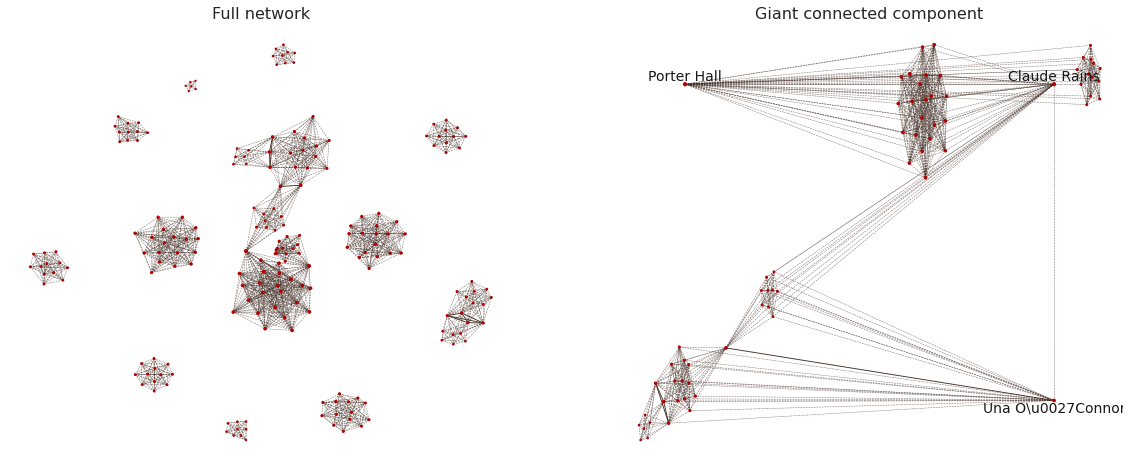

  3%|▎         | 67/2000 [00:00<00:02, 666.27it/s]

BarnesHut Approximation  took  1.48  seconds
Repulsion forces  took  2.22  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


100%|██████████| 2000/2000 [00:03<00:00, 589.88it/s]


BarnesHut Approximation  took  1.31  seconds
Repulsion forces  took  1.52  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds
1940s


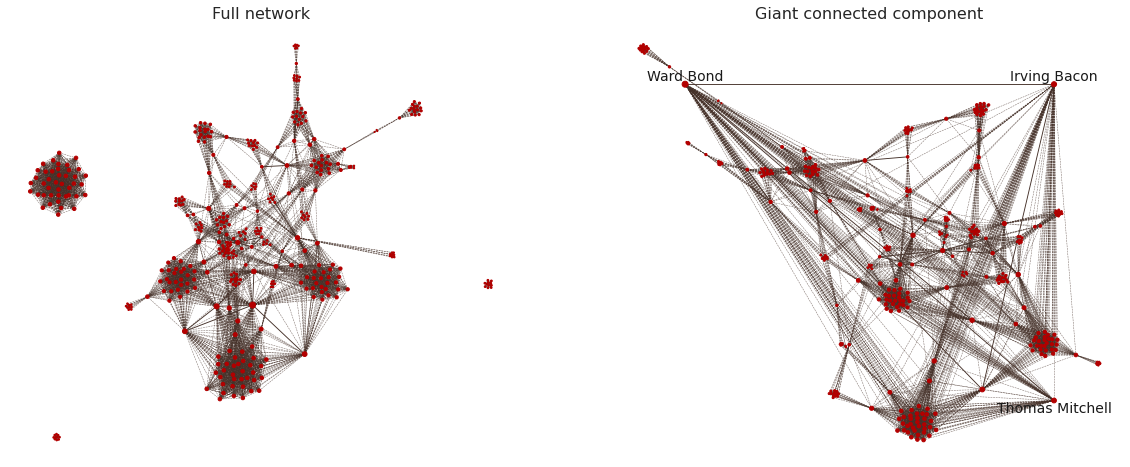

  0%|          | 0/2000 [00:00<?, ?it/s]

BarnesHut Approximation  took  4.67  seconds
Repulsion forces  took  5.01  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.52  seconds
AdjustSpeedAndApplyForces step  took  0.36  seconds


100%|██████████| 2000/2000 [00:07<00:00, 275.12it/s]


BarnesHut Approximation  took  3.02  seconds
Repulsion forces  took  3.00  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.50  seconds
AdjustSpeedAndApplyForces step  took  0.32  seconds
1950s


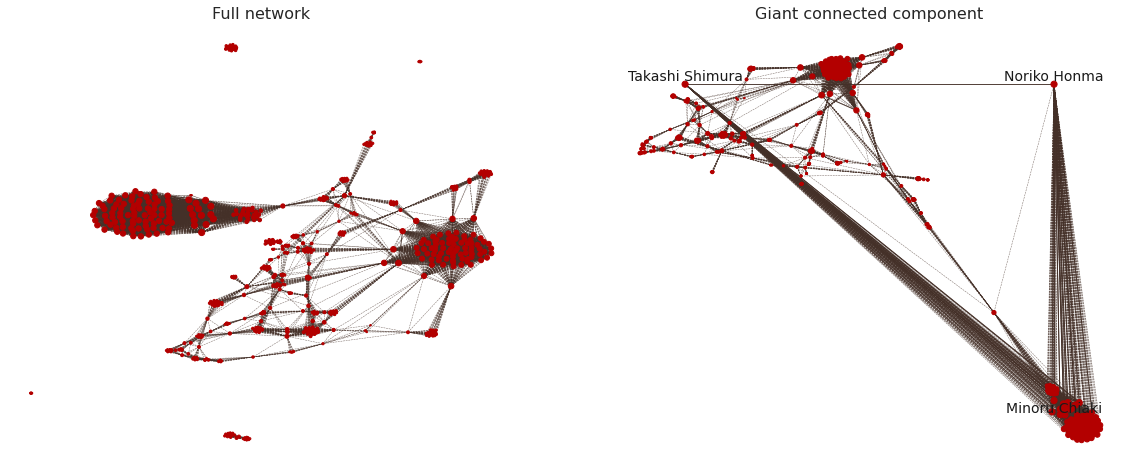

  0%|          | 0/2000 [00:00<?, ?it/s]

BarnesHut Approximation  took  7.53  seconds
Repulsion forces  took  6.96  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.56  seconds
AdjustSpeedAndApplyForces step  took  0.52  seconds


100%|██████████| 2000/2000 [00:09<00:00, 203.79it/s]


BarnesHut Approximation  took  4.70  seconds
Repulsion forces  took  3.88  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.38  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds
1960s


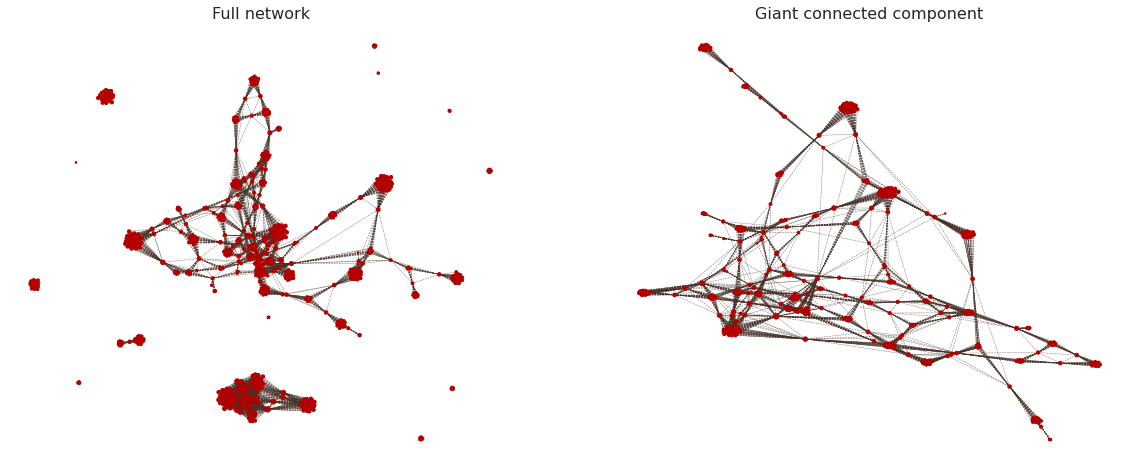

100%|██████████| 2000/2000 [00:42<00:00, 47.52it/s]


BarnesHut Approximation  took  20.65  seconds
Repulsion forces  took  17.19  seconds
Gravitational forces  took  0.20  seconds
Attraction forces  took  1.87  seconds
AdjustSpeedAndApplyForces step  took  0.97  seconds


100%|██████████| 2000/2000 [00:32<00:00, 62.33it/s]


BarnesHut Approximation  took  16.51  seconds
Repulsion forces  took  11.94  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  1.69  seconds
AdjustSpeedAndApplyForces step  took  0.82  seconds
1970s


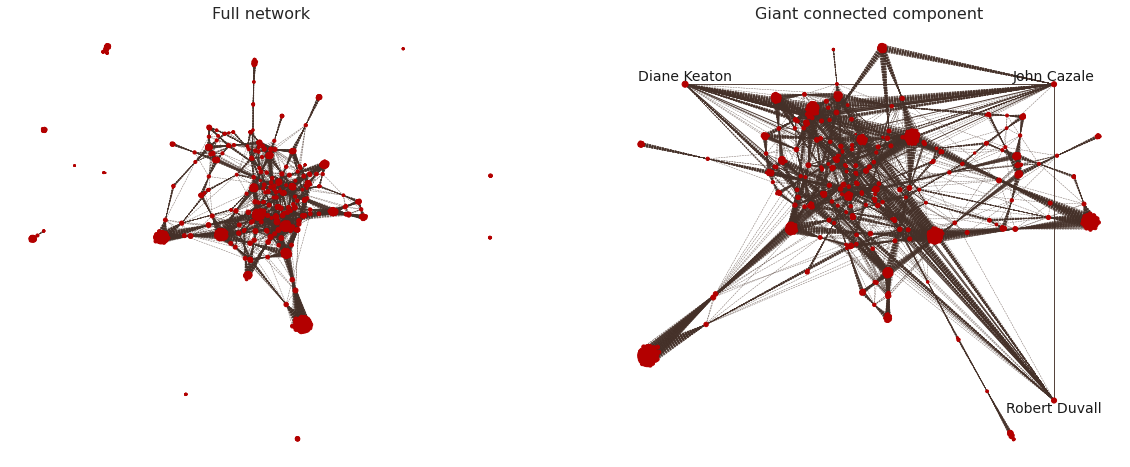

100%|██████████| 2000/2000 [01:15<00:00, 26.43it/s]


BarnesHut Approximation  took  39.30  seconds
Repulsion forces  took  28.41  seconds
Gravitational forces  took  0.31  seconds
Attraction forces  took  4.21  seconds
AdjustSpeedAndApplyForces step  took  1.53  seconds


100%|██████████| 2000/2000 [01:10<00:00, 28.33it/s]


BarnesHut Approximation  took  37.07  seconds
Repulsion forces  took  25.65  seconds
Gravitational forces  took  0.30  seconds
Attraction forces  took  4.09  seconds
AdjustSpeedAndApplyForces step  took  1.47  seconds
1980s


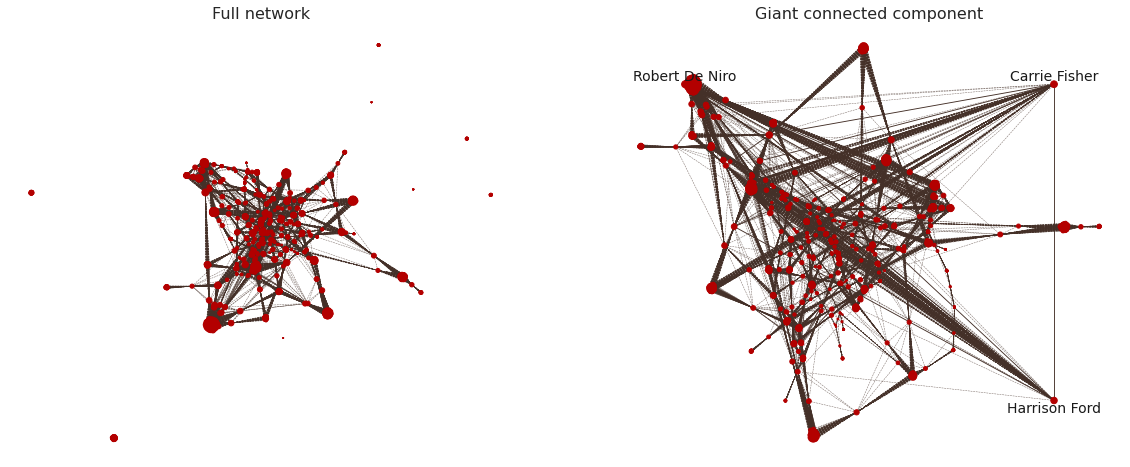

100%|██████████| 2000/2000 [03:01<00:00, 11.02it/s]


BarnesHut Approximation  took  90.54  seconds
Repulsion forces  took  73.49  seconds
Gravitational forces  took  0.58  seconds
Attraction forces  took  9.60  seconds
AdjustSpeedAndApplyForces step  took  2.80  seconds


100%|██████████| 2000/2000 [02:40<00:00, 12.50it/s]


BarnesHut Approximation  took  86.70  seconds
Repulsion forces  took  57.11  seconds
Gravitational forces  took  0.56  seconds
Attraction forces  took  9.41  seconds
AdjustSpeedAndApplyForces step  took  2.73  seconds
1990s


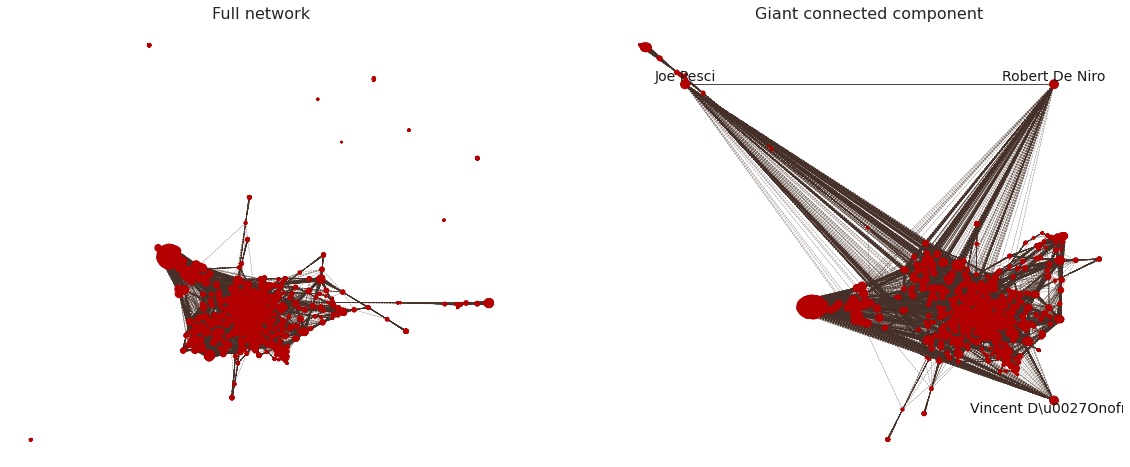

100%|██████████| 2000/2000 [05:03<00:00,  6.59it/s]


BarnesHut Approximation  took  160.70  seconds
Repulsion forces  took  118.33  seconds
Gravitational forces  took  1.04  seconds
Attraction forces  took  13.45  seconds
AdjustSpeedAndApplyForces step  took  4.37  seconds


100%|██████████| 2000/2000 [04:18<00:00,  7.74it/s]


BarnesHut Approximation  took  144.27  seconds
Repulsion forces  took  91.36  seconds
Gravitational forces  took  0.90  seconds
Attraction forces  took  12.13  seconds
AdjustSpeedAndApplyForces step  took  3.98  seconds
2000s


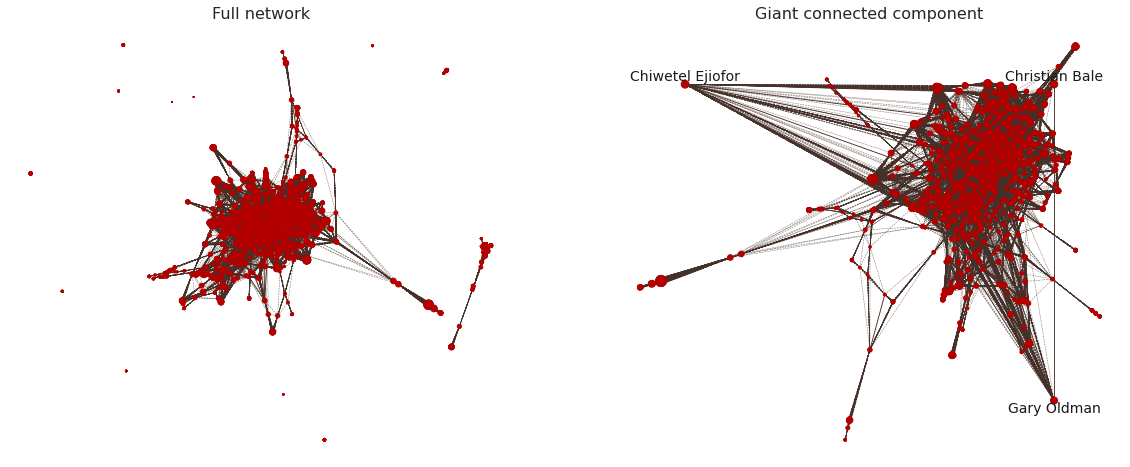

100%|██████████| 2000/2000 [05:01<00:00,  6.64it/s]


BarnesHut Approximation  took  161.03  seconds
Repulsion forces  took  115.37  seconds
Gravitational forces  took  1.01  seconds
Attraction forces  took  13.86  seconds
AdjustSpeedAndApplyForces step  took  4.17  seconds


100%|██████████| 2000/2000 [04:29<00:00,  7.41it/s]


BarnesHut Approximation  took  148.68  seconds
Repulsion forces  took  97.58  seconds
Gravitational forces  took  0.89  seconds
Attraction forces  took  12.90  seconds
AdjustSpeedAndApplyForces step  took  4.06  seconds
2010s


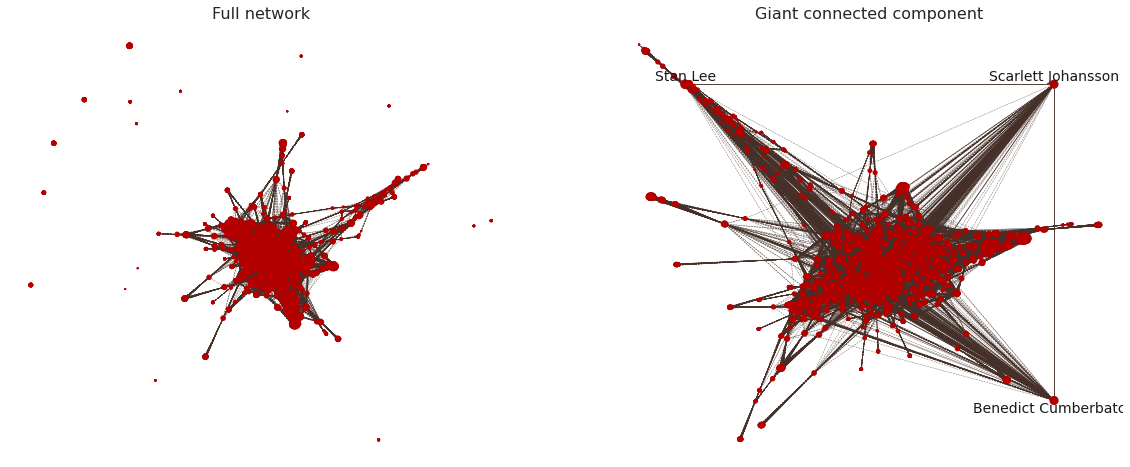

In [ ]:
decades = ['1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

for (idx, decade) in enumerate(decades):
  G_actors = pickle.load(open(mount_path+'../Graphs/graph_'+decade+'.txt', "rb"))
  GCC_actors = max([G_actors.subgraph(c).copy() for c in nx.connected_components(G_actors)], key=len)
  degree_sequence = sorted([(d,n) for n, d in G_actors.degree(weight='weight')], reverse=False)
  if idx < 5: 
    positions1, positions2 = compute_positions(G_actors, GCC_actors, 0.0001,0.8)
    m = 0.3
  else:   
    positions1, positions2 = compute_positions(G_actors, GCC_actors, 0.0001,1.5)
    m = 0.15
  positions2, label_pos, labels = update_positions(positions2, degree_sequence)  
  if decade == '1960s':
    labels = {}
  print(decade)  
  plot_network(G_actors, GCC_actors, positions1, positions2,labels, label_pos, decade, m)

### Discussion of decades

**1920s**

Based on the top 1000 rated movies, the network of actors in the 1920s consists of 8 connected components. As it was shown in the statistics of all 1000 movies, only nine was made in the 1920s. Thus, the eight connected components reflects that seven of these just corresponds to one movie, while the last one is the network of two movies. The plot of the giant connected components shows that Joe Keaton and Buster Keaton starred in both of these movies and hence, the edge between these two actors is solid, which represent that they are connected by more than one movie. The fact that Wolfgang Heinz is shown as the actor with the third highest degree is just a coincidence and it might as well have been one of the other actors in the particular movie that he starred in. The seven components that each represent the cast of a movie are so called cliques, or complete graphs, where all nodes are connected, which can also be seen at the plot of the full network to the left, where there are edges between all nodes within the cliques.
It is found that the minimum node degree is three, meaning that there is a movie with a cast of only four, while the maximum degree of a node is 13. Since this degree belongs to Buster Keaton and Joe Keaton it reflects that they in total are connected to 13 other actors by starring in two movies. Since the network in this decade is very disconnected, the plot of the degree distribution can almost be viewed as the number of actors in each movies. However, note that it is not exatly the case, but it is a good indication of the cast sizes, since only two movies are connected in this decade.

**1930s**

It was shown in the statistics that 17 movies on the IMDB list was produced in the 1930s, but now the network consists of 12 components, so the network of actors have become more connected in this decade compared to the 1920s. Furthermore, the giant connected component now includes 32.9% of all the nodes in the network. However, the maximum edge weight is still 2, which means that two actors have not starred together in more than two movies in this decade, and the average edge weight is 1.01, so in general actors have only starred in one of the top rated movies together in this decade. The degree distribution shows that two actors have degrees of 36, resppectively 34, which is significantly higher that the rest of the actors. These two actors are Porter Hall and Claudia Rains, which are labelled in the visualization of the giant connected component. Since these degrees are that much higher that the rest we start to see hub-like tendencies in the full network, which can also be seen on the plot of the full network, where the two biggest nodes looks like hubs.

**1940s**

In the 1940s we find that there only are four components, and the giant component is significantly bigger that in earlier decades, where 85.8% of all nodes are represented in the giant component. The highest degree of a nodes is also increased significantly to 122, which belong to the actor Ward Bond. The visualization of the giant connected components shows that he is connected to the actors with the second and third highests degrees with edges of weight more than one, so he has participated in several movies with the two actors. In addition, the highest weight of an egde is now 3, so at least two actors have starred in three movies together. Even though the majority of the actors are in the giant connected component, there appears to be quite a large network in the second largest component, which on the plot appears to be a clique, so we investigate what this component is.

In [ ]:
G_actors = pickle.load(open(mount_path+'../Graphs/graph_1940s.txt', "rb"))
G_second = sorted([G_actors.subgraph(c).copy() for c in nx.connected_components(G_actors)], key=len)[1]
degree_sequence = sorted([(d,n) for n, d in G_second.degree(weight='weight')], reverse=False)
degree_sequence

[(10, 'Carlo Jachino'),
 (10, 'Elena Altieri'),
 (10, 'Emma Druetti'),
 (10, 'Enzo Staiola'),
 (10, 'Fausto Guerzoni'),
 (10, 'Gino Saltamerenda'),
 (10, 'Giulio Chiari'),
 (10, 'Lamberto Maggiorani'),
 (10, 'Lianella Carell'),
 (10, 'Michele Sakara'),
 (10, 'Vittorio Antonucci')]

We see that all actors in this component have a degree of 10, so they indeed represent a movie. Furthermore, all the names appear to be Italian, so we suggest that this is an Italian movie and will now figure out which one it is. 


In [ ]:
movie = df_actors[df_actors['ActorName']=='Carlo Jachino']['MovieIDs_1940s'].values[0][0]
df_movies[df_movies['MovieID'] == movie]

MovieID  ...                                           Creators
113  tt0040522  ...  [Cesare Zavattini, Luigi Bartolini, Oreste Bia...

[1 rows x 21 columns]

The movie is Bicycle Thieves. Interestingly, this is an Italian movie, and thus this can explain why they are not connected to the other nodes, which might be movies from the USA or other countries.

**1950s**

In the 1950s we see that the three nodes with the highest degrees all have Japanese-sounding names, which is quite interesting since the majority of the 1000 movies are produced in USA. Thus, we investigate this further and find the movies that are produced in Japan in the 1950s.

In [ ]:
df_movies[df_movies['Country'] == 'Japan'][df_movies['Decade'] == '1950s']

MovieID  ...                                           Creators
30   tt0047478  ...  [Akira Kurosawa, Shinobu Hashimoto, Hideo Ogun...
112  tt0044741  ...   [Akira Kurosawa, Shinobu Hashimoto, Hideo Oguni]
169  tt0042876  ...  [Ryûnosuke Akutagawa, Akira Kurosawa, Shinobu ...

[3 rows x 21 columns]

This shows, that of the 3 of the 1000 top rated movies was produced in Japan in the 1950s and all was directed by the Japanese director Akira Kurosawa. The degree distribution shows that four actor have the highest degree of 144, but actually ten other actor have a degree of 137, so again we observe that we get more and more hub-tendencies in the network.

**1960s**

The 1960s is a quite interesting decade, where the three nodes with the highest degrees are not part of the giant connected component. Instead we figure out who it is: 

In [ ]:
G_actors = pickle.load(open(mount_path+'../Graphs/graph_1960s.txt', "rb"))
degree_sequence = sorted([(d,n) for n, d in G_actors.degree(weight='weight')], reverse=False)
degree_sequence[-3:]

[(115, 'Toshirô Mifune'), (115, 'Yoshio Tsuchiya'), (115, 'Yutaka Sada')]

This shows, that the actors with the highest degrees are Toshirô Mifune, Yoshio Tsuchiya and Yutaka Sada, but when plotting the giant component it was found, that these are not part of the giant connected component. Instead they must be part of the second biggest component, which also appears to be quite large. Again, we see that these names are Japanese-sounding, so the second largest component is a component of Japanese movies. An explanation of why the actors with the highest degrees are not in the giant connected component could be, that the giant connected component consists of more, smaller movies that are connected by actors that star in more of these movies. On the contrary, the second largest component consists of fewer movies but with bigger casts, which results in higher degrees for the actors that star in several of these movies.

**1970s**

In the 1970s the network of actors consists of 2043 nodes, with one giant connected component and ten smaller components. The degree distribution shows that the actor with the highest degree, Diane Keaton, has a degree of 250, which is signifantly higher than the rest of the actors. The plot of the giant connected components shows, that the actors with the highest degrees are connected by edges with a weight higher than one, so these actors have starred in several movies together. Furthermore it is find that 85.2% of all nodes are included in the giant connected component and that the average shortest path between two nodes in this network is 2.97.

**1980s**

In the 1980s the network of actors becomes even more connected with a giant connected component that consists of 93.1% of all the nodes. The actors with the highest degrees in this decade is Robert De Niro, Carrie Fisher and Harrison Ford, who have degrees of 332, 314 and 298, respectively. The degree distribution furthermore shows that there are multiple actors with degrees above 150, while the majority har significantly lower degrees. However, we observe some interesting spikes in the degree distribution with many actors having degrees of 62, 90, 104 and 146, respectively. These spikes might indicate the cast sizes of particular movies, since so many actors fall within these degrees.

**1990s**

In the 1990s we again find Robert De Niro to be one of the three nodes with the highest degree. This indicate that he indeed was very active in his acting career in the 1980s and 1990s. Furthermore we observe an even larger giant connected component with 95.2% of all nodes. The smaller components might just consist of one movie, which will explain the minimum degree of 9, which is most likely representing that the cast of a movie is 10. Even though the average edge weight is still 1, we now found that the highest edge weight is 6, which means that at least two actors have starred together in 6 of the 1000 top rated IMDB movies in the 1990s. This is quite impressive!

**2000s**

The 2000s is actually the decade with the biggest network, which consists of 9126 nodes and it is also the decade with the most movies on the IMDB list, where 213 of the movies were produced in this decade. However, interestingly the giant connected component actually contains a lower percentage of the total number of nodes compared to the 1990s, since 91.3% of all nodes are contained in the giant component in the 2000s compared to 95.2% in the 1990s. Furthermore, the maximum edge weight in this decade is 4, compared to 6 in the 1990s, so it appears that there might be a greater variance in the actors used in this decade compared to the 1990s. Another interesting observation is the fact that the actor with the highest degree, Chiwetel Ejiofor, is not connected to the actor with the second highest degree, Christian Bale, which has been the case in the earlier decades. However, we do see that Christian Bale is connected to Gary Oldman, who is the actor with the third highest degree, and these are actually connected by an edge with a weight higher than 1, so they have starred together in several of the top rated movies on IMDB in the 2000s.

**2010s**

Finally, we look at the network of actors from the 2010s. We observe that the actor with the highest degree, Stan Lee, has a degree of 633, so in the 2010s he has starred together with many actors - he has not starred together with exactly 633, since he have starred together with some of the actors in more than one movie. As an example, on the visualization of the giant connected component we observe that he is connected to Scarlett Johansson by an edge with weight more than 1, so these two actors have starred in at least two of the top rated movies in the 2010s. Furthermore we observe that the 2010s actually consists of 18 components, which suggests that the variety of used actors in this decade is bigger compared to some of the earlier decades. It could further indicate that countries with smaller movie indutries compared to Hollywood, produce movies that make it to the top 1000 rated movies on IMDB and thereby results in multiple, smaller components in the entire network.

# 4. Discussion

In the beginning of the project we found a list of the 1000 most popular actors and started to create our network based on this. We then read a comment on Slack from a TA, who wrote that the network should consist of at least 100 nodes. Based on this we decided to decrease the size of our network and instead found a list of the 100 most popular actors and a list of 100 most pupular actresses, which we combined to create a network of 200 nodes. However, we realized that this would be a quite small network, which would be very focused on exactly these actors. Instead we decided to extract the 1000 top rated movies on IMDB as of today and use the cast from the movies to create the network of actors, as we hoped this would result in a greater variance in the degree distribution. In that way we ended up using a lot of time on data extraction and data cleaning on different data sets, so it would have been beneficial had we earlier in the process realized what data would be better to use and focus on that earlier.  

In relation to the data, the network is as mentioned based ont the cast of the 1000 top rated movies on IMDB as of today. This clearly influences the network since it includes popular actors and has significantly more movies from later decades. It would have been very interesting to gather the data in a different way; optimally to create a network of all actors in the world, as this would likely result in a different degree distribution, but it would also result in a very big network. Another idea would be to find a list of the most popular movies from each decade, if these could be found, and base the network of the casts of these. This would likely give some even more valuable insigts in each decade that what we saw with this data set. 


Another interesting thing to work on had we had more time, would be to include and analyse a bipartite graph. As mentioned, the network of actors is based on the top rated movies on IMDB. Hence, there also exists a network of movies and it could have been relevant to draw the bipartite graph consisting of all actors and all movies in two disjoint sets, where each link would connect a movie and an actor. The network of actors that we have created is actually one projection of the bipartite graph, were two nodes are connected if they have played in the same movie. Hence, it would be interesting to investigate how the communities would have looked if we had made the community partition based on the whole bipartite graph. 


Our clear vision of the project was to create a network that it was possible to understand and present the analyses in a clear way. We believe we accomplished this by e.g. making interactive plots with hover options using Plotly, and by including pictures of the top three actors in each genre, as people tend to remember faces better than names. 
We had not worked with Plotly before, so this was a new skill we had to aquire, which we are sure will be very useful when working with data and visualization in the future, since the interactive tools make the plots more powerfull. 

Another goal was to investigate how the network of actors, based on the IMDB list, changed from decade to decade. We believe we have accomplished this by looking at the degree distribution and visualization of the network from each decade, and have clearly shown how the network becomes more and more connected. Another vision was to see if we could partition the actors into communities and understand these partiotions. By looking at the top five communities we believe that we accomplished to understand the partition of the actors into these communities by investigating both countries, genres, release dates and our general knowledge about popular actors and movies. Finally we wanted to investigate if it was possible to see differencs between the most popular genres. We believe we ccomplished this, by e.g. looking at the average age of a cast and by using text analysis on the plot summary and the list of keywords for each movie.




 

# 5. Contributions

Both members of the group have contributed equally to this project, but below it is specified which group member was the *main responsible* for each part of the project.

- Data extraction and cleaning: Amalie and Karen 
- Creating graphs: Karen 
- Discussion: Amalie
- Webpage: Amalie and Karen 

For the following sections in the notebook, including everything under that section, the *main responsible* for each section is specified:

- Basic statistics: Amalie
- Tools, theory and analysis, *Genre Analysis*: Karen
- Tools, theory and analysis, *Communities*: Karen
- Tools, theory and analysis, *Decades*: Amalie
